# Problem Statement

This model predicts how much of a loan will be granted to an applicant. The model uses different information about the applicant profile and predict how much will be approved. Usually the applicant with a higher credit score, a co-applicant will be granted a larger loan amount. It depends also on how much the applicant has requested.


# 0. Import the necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from pandas_profiling import ProfileReport
from pathlib import Path
from sklearn.metrics import mean_squared_error
from scipy import stats
from yellowbrick.model_selection import FeatureImportances
import shap
import joblib
%matplotlib inline

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
C:\Users\lenovo\AppData\Local\Temp\ipykernel_14612\1258138734.py:21: DeprecationWarning

# 1. Get the data

## 1.1 Import csv file

In [2]:
train_original = pd.read_csv('datasets/train.csv')
test_original = pd.read_csv('datasets/test.csv')

## 1.2 Split the data into training and test sets

In [3]:
train_original.shape

(30000, 24)

In [4]:
test_original.shape

(20000, 23)

In [5]:
train_original.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')

In [6]:
test_original.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price'],
      dtype='object')

In [7]:
pd.set_option('display.max_columns', None)
train_original.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,241.08,N,N,3.0,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,495.81,N,Y,1.0,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,171.95,N,Y,1.0,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,298.54,N,Y,2.0,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,491.41,N,Y,NaN,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


In [8]:
test_original.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price
0,C-26247,Tandra Olszewski,F,47,3472.69,Low,Commercial associate,Managers,Semi-Urban,137088.98,396.72,N,N,2.0,799.14,0,Unpossessed,843,3472.69,2,Urban,1,236644.5
1,C-35067,Jeannette Cha,F,57,1184.84,Low,Working,Sales staff,Rural,104771.59,463.76,Y,Y,2.0,833.31,0,Unpossessed,22,1184.84,1,Rural,1,142357.3
2,C-34590,Keva Godfrey,F,52,1266.27,Low,Working,NaN,Semi-Urban,176684.91,493.15,N,Y,3.0,627.44,0,Unpossessed,1,1266.27,1,Urban,1,300991.24
3,C-16668,Elva Sackett,M,65,1369.72,High,Pensioner,NaN,Rural,97009.18,446.15,N,Y,2.0,833.20,0,Inactive,730,1369.72,1,Semi-Urban,0,125612.1
4,C-12196,Sade Constable,F,60,1939.23,High,Pensioner,NaN,Urban,109980.00,370.10,N,N,NaN,NaN,0,NaN,356,1939.23,4,Semi-Urban,1,180908.0


Since the test dataset does not have the target variable (Loan Sanction Amount), we will split the train dataset into a new train and test dataset.

In [9]:
full_data = train_original

In [10]:
full_data.shape

(30000, 24)

In [11]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [12]:
loan_amt_train_original, loan_amt_test_original = data_split(full_data, 0.2)

In [13]:
loan_amt_train_copy, loan_amt_test_copy = loan_amt_train_original.copy(), loan_amt_test_original.copy()

In [14]:
loan_amt_train_copy.shape

(24000, 24)

In [15]:
loan_amt_test_copy.shape

(6000, 24)

# 2. Explore the data

## 2.1 Quick glance at the data

In [16]:
loan_amt_train_copy.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-15808,Minerva Dundon,M,27,12398.65,Low,Working,Managers,Urban,294604.89,1255.89,Y,N,2.0,NaN,0,Active,540,12398.65,4,Semi-Urban,1,526542.91,235683.91
1,C-29367,Darius Granado,M,36,NaN,Low,Working,NaN,Semi-Urban,132263.08,500.43,N,N,1.0,646.05,1,NaN,320,NaN,3,Urban,1,250293.24,0.00
2,C-20386,Verlene Hagar,M,52,NaN,Low,Commercial associate,Sales staff,Semi-Urban,112307.54,539.09,N,Y,1.0,706.42,0,Active,6,NaN,2,Rural,1,157866.23,72999.90
3,C-14237,Yang Leitner,F,18,NaN,Low,Working,Laborers,Rural,24268.35,168.21,N,N,2.0,640.23,0,Unpossessed,869,NaN,2,Urban,1,30470.51,0.00
4,C-14759,Ilda Jeffords,F,18,2203.52,Low,Working,Laborers,Semi-Urban,76342.04,681.95,N,Y,2.0,835.55,0,Inactive,21,2203.52,3,Urban,1,142224.12,57256.53


In [17]:
loan_amt_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  24000 non-null  object 
 1   Name                         24000 non-null  object 
 2   Gender                       23954 non-null  object 
 3   Age                          24000 non-null  int64  
 4   Income (USD)                 20352 non-null  float64
 5   Income Stability             22676 non-null  object 
 6   Profession                   24000 non-null  object 
 7   Type of Employment           18228 non-null  object 
 8   Location                     24000 non-null  object 
 9   Loan Amount Request (USD)    24000 non-null  float64
 10  Current Loan Expenses (USD)  23872 non-null  float64
 11  Expense Type 1               24000 non-null  object 
 12  Expense Type 2               24000 non-null  object 
 13  Dependents      

In [18]:
loan_amt_train_copy.describe()

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,24000.000000,20352.000000,24000.000000,23872.000000,21983.000000,22623.000000,24000.000000,24000.000000,20149.000000,24000.000000,24000.000000,2.400000e+04,23725.000000
mean,40.058417,2567.533530,89075.615086,401.409325,2.250512,739.726632,0.193875,502.302000,2567.841029,2.463708,-4.686333,1.320183e+05,47680.600489
std,16.029209,1775.075442,59637.687461,241.893479,0.947379,72.271823,0.395340,288.707474,1776.812939,1.121005,74.227397,9.356624e+04,48224.124688
min,18.000000,378.760000,6048.240000,-999.000000,1.000000,580.000000,0.000000,1.000000,378.760000,1.000000,-999.000000,-9.990000e+02,-999.000000
25%,25.000000,1652.707500,41272.637500,248.932500,2.000000,681.225000,0.000000,251.000000,1653.040000,1.000000,1.000000,6.079394e+04,0.000000
50%,40.000000,2229.965000,75326.655000,375.275000,2.000000,739.880000,0.000000,503.000000,2231.100000,2.000000,1.000000,1.101687e+05,35273.020000
75%,55.000000,3092.775000,120378.247500,521.215000,3.000000,799.090000,0.000000,753.000000,3094.050000,3.000000,1.000000,1.790840e+05,74217.940000
max,65.000000,122966.280000,621497.820000,3419.660000,10.000000,896.260000,1.000000,999.000000,122966.280000,4.000000,1.000000,1.077967e+06,395368.740000


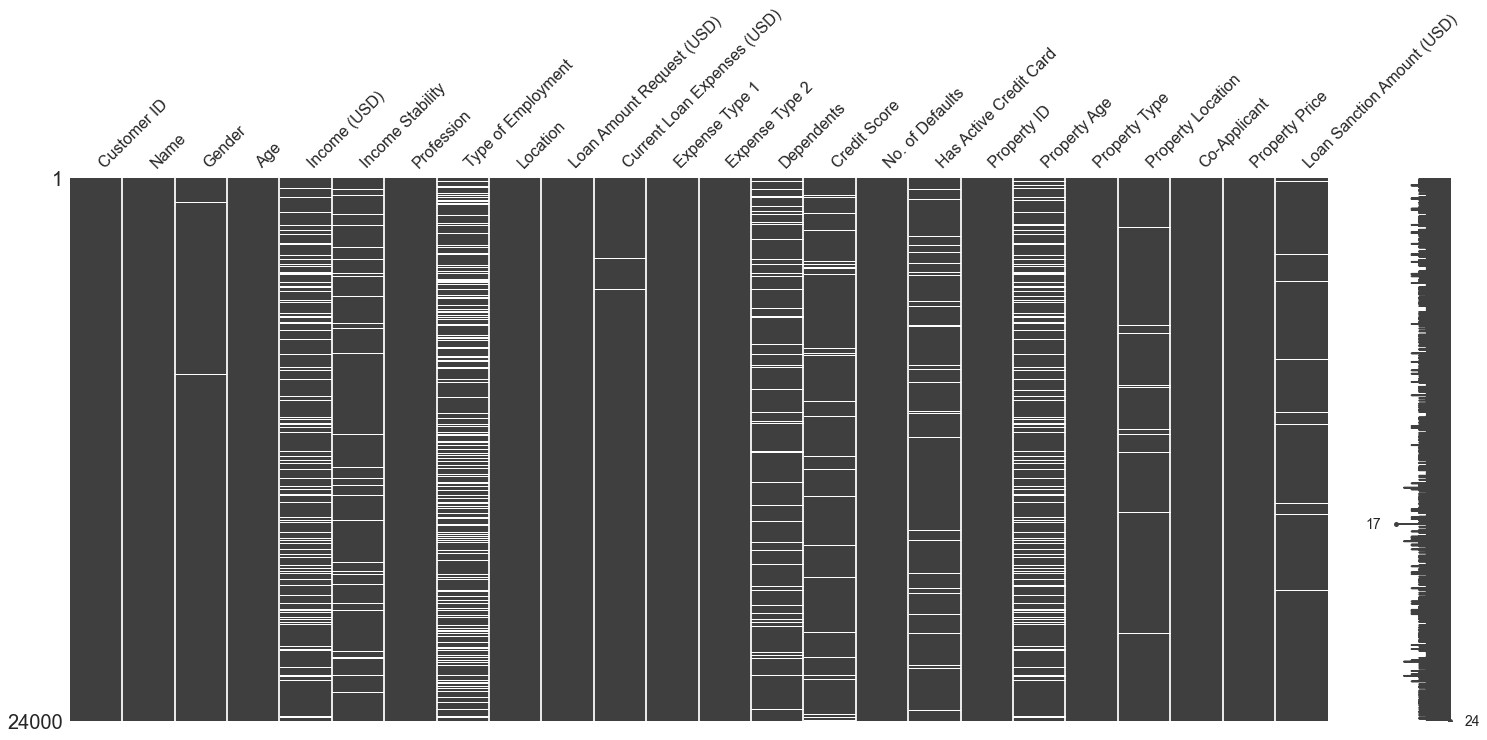

In [19]:
msno.matrix(loan_amt_train_copy)
plt.show()

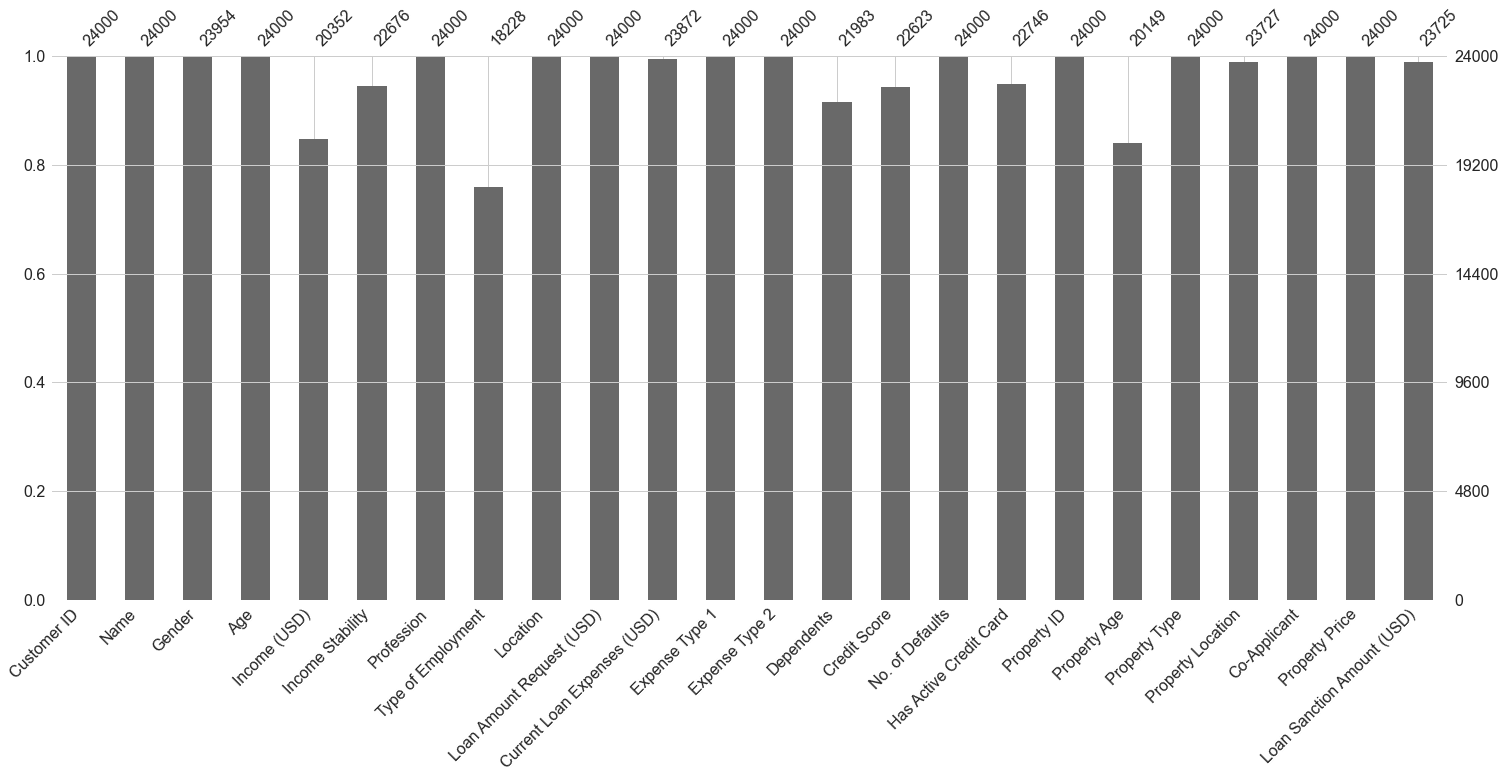

In [20]:
msno.bar(loan_amt_train_copy)
plt.show()

## 2.2 Functions used in the EDA of each feature

In [21]:
def value_cnt_norm_cal(df,feature):
    '''
    Function that will return the value count and frequency of each observation within a feature
    '''
    ftr_value_cnt = df[feature].value_counts()
    # normalize the value count
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [22]:
def gen_info_feat(df,feature):
    '''
    function to create display general information about the feature
    '''
    match feature:
        case 'Age' | 'Income (USD)' | 'Loan Amount Request (USD)' | 'Current Loan Expenses (USD)' | 'Credit Score' | 'Property Price' | 'Loan Sanction Amount (USD)':
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            print('Skewness:\n{}'.format(df[feature].skew()))
        case 'Property Age':
            print('Description:\n{}'.format(df[feature].describe()/365.25))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            print('Skewness:\n{}'.format(df[feature].skew()))
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))

In [23]:
def create_bar_plot(df,feature):
    '''
    function to create a bar chart plot
    '''
    match feature:
        case 'Profession' | 'Type of Employment' | 'Dependents':
            fig, ax = plt.subplots(figsize=(8,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0], color='dimgray')
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.xticks(rotation=45,ha='right')
            plt.title('{} count'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.xticks(rotation=45,ha='right')
            plt.title('{} count'.format(feature))
            return plt.show()

In [24]:
def create_donnut_pie_chart(df,feature):
    '''
    function to create a donnut pie chart
    '''
    ratio_size = value_cnt_norm_cal(df, feature)
    ratio_size_len = len(ratio_size.index)
    ratio_list = []
    for i in range(ratio_size_len):
        ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
    fig, ax = plt.subplots(figsize=(8,8))
    # %1.2f%% display decimals in the pie chart with 2 decimal places
    plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
    plt.title('Pie chart of {}'.format(feature))
    plt.legend(loc='best')
    plt.axis('equal')
    # add a circle at the center to transform it in a donut chart
    circle=plt.Circle( (0,0), 0.8, color='white')
    p=plt.gcf()
    p.gca().add_artist(circle)
    return plt.show()

In [25]:
def create_box_plot(df,feature):
    '''
    function to create a box plot
    '''
    match feature:
        case 'Property Age':
            fig, ax = plt.subplots(figsize=(2, 8))
            sns.boxplot(y=df[feature]/365.25)
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()

In [26]:
def create_hist_plot(df,feature, the_bins=50):
    '''
    function to create a histogram plot
    '''
    match feature:
        case 'Property Age':
            fig, ax = plt.subplots(figsize=(18, 10))
            sns.histplot(df[feature]/365.25, bins=the_bins, kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

In [27]:
def missing_val_norm(df,feature):
    feat_nan_count = df[feature].isnull().sum()
    rows_count = df.shape[0]
    return 'The percentage of missing rows is {:.2f} %'.format(feat_nan_count * 100 / rows_count)

## 2.3. Univariate analysis

### 2.3.1 Gender

In [28]:
gen_info_feat(loan_amt_train_copy,'Gender')

Description:
count     23954
unique        2
top           M
freq      12087
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
M  12087      50.459213
F  11867      49.540787


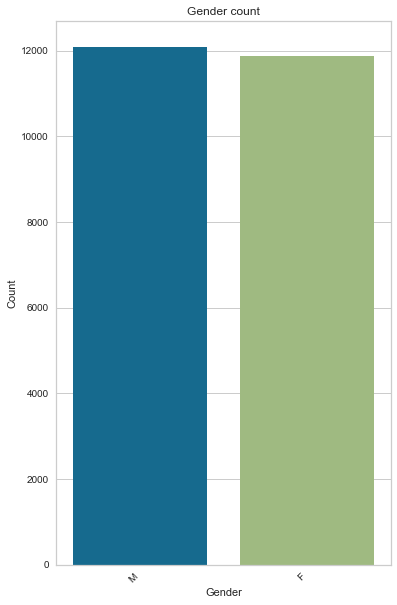

In [29]:
create_bar_plot(loan_amt_train_copy,'Gender')

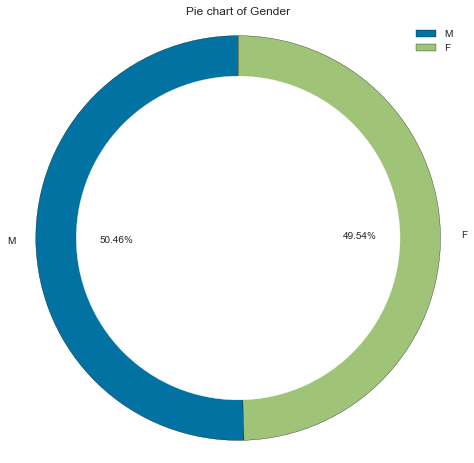

In [30]:
create_donnut_pie_chart(loan_amt_train_copy,'Gender')

Interpretation:
- We have almost the same number of Male vs Female (50.46% vs 49.54%)

### 2.3.2 Age

In [31]:
gen_info_feat(loan_amt_train_copy, 'Age')

Description:
count    24000.000000
mean        40.058417
std         16.029209
min         18.000000
25%         25.000000
50%         40.000000
75%         55.000000
max         65.000000
Name: Age, dtype: float64
**************************************************
Object type:
int64
**************************************************
Skewness:
0.05019079901588933


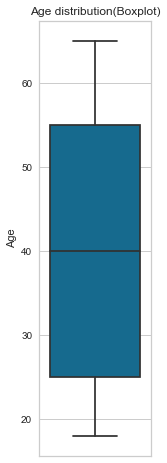

In [32]:
create_box_plot(loan_amt_train_copy, 'Age')

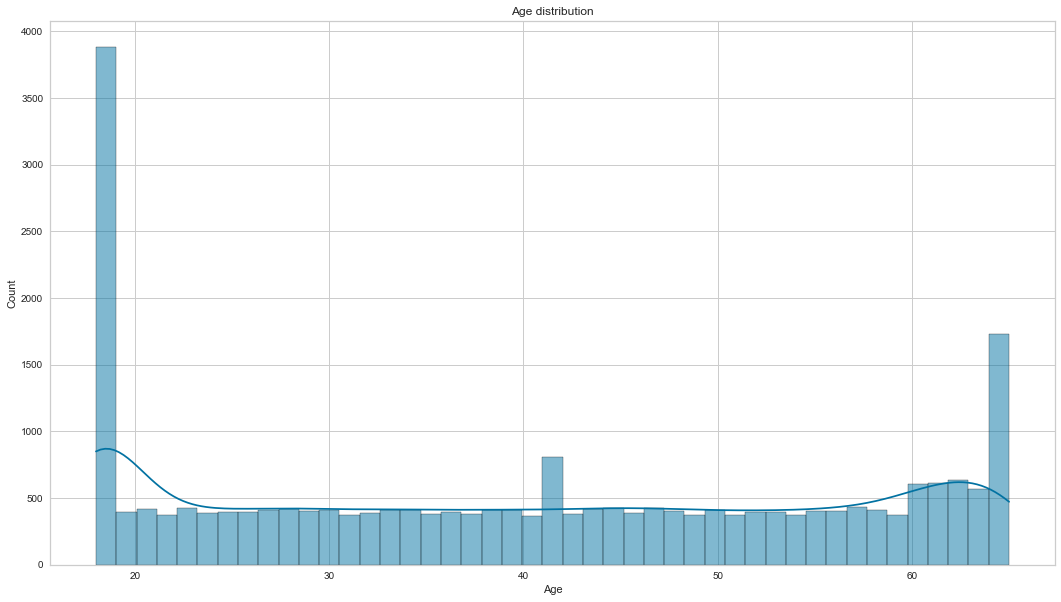

In [33]:
create_hist_plot(loan_amt_train_copy, 'Age', the_bins=45)

Interpretation:
- Age is not normally distributed
- We have a large number of applicants who are 18 and 65 years old
- Mean and median of age is 40 years old

### 2.3.3 Income

In [34]:
gen_info_feat(loan_amt_train_copy, 'Income (USD)')

Description:
count     20352.000000
mean       2567.533530
std        1775.075442
min         378.760000
25%        1652.707500
50%        2229.965000
75%        3092.775000
max      122966.280000
Name: Income (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
19.759160741711046


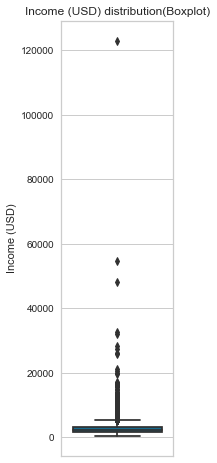

In [35]:
create_box_plot(loan_amt_train_copy, 'Income (USD)')

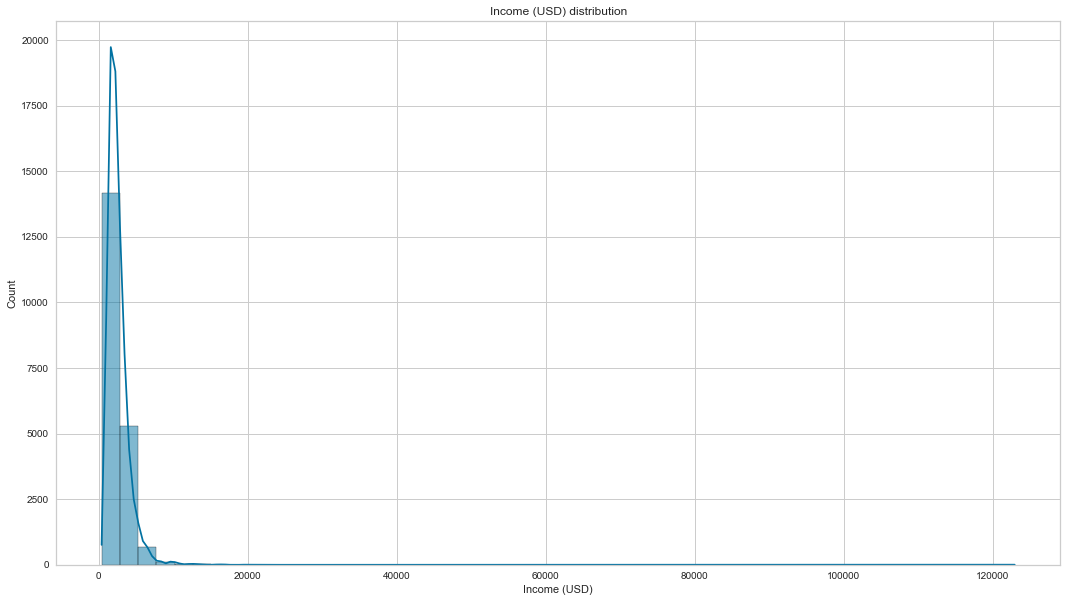

In [36]:
create_hist_plot(loan_amt_train_copy, 'Income (USD)', the_bins=50)

In [37]:
missing_val_norm(loan_amt_train_copy, 'Income (USD)')

'The percentage of missing rows is 15.20 %'

Interpretation:
- The Income feature has 15% of its data missing.
- The Income is positively skewed.
- The Income has a lot of outliers.
- The median income is $2229.

### 2.3.4 Income stability

In [38]:
gen_info_feat(loan_amt_train_copy,'Income Stability')

Description:
count     22676
unique        2
top         Low
freq      20617
Name: Income Stability, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
      Count  Frequency (%)
Low   20617      90.919915
High   2059       9.080085


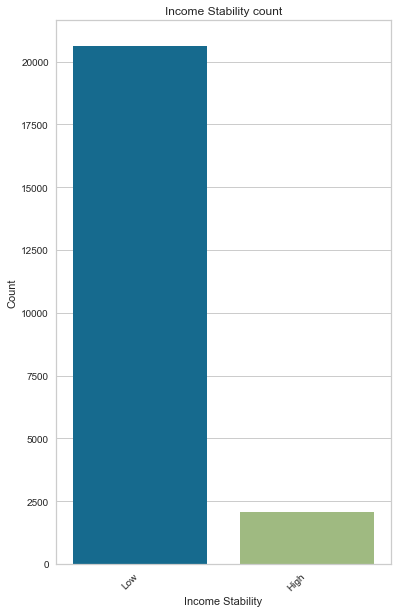

In [39]:
create_bar_plot(loan_amt_train_copy,'Income Stability')

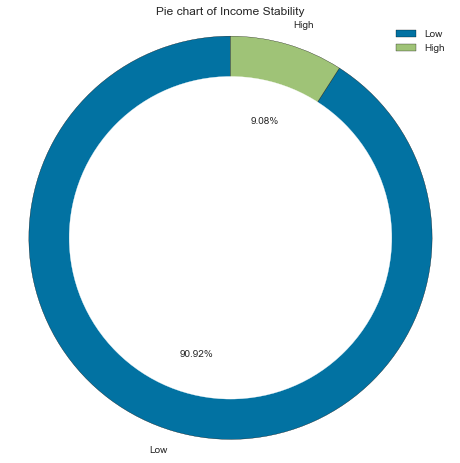

In [40]:
create_donnut_pie_chart(loan_amt_train_copy,'Income Stability')

Interpretation:
- Less than 10% of applicants have a high income stability
- 90% of applicants have a low income stability

### 2.3.5 Profession

In [41]:
gen_info_feat(loan_amt_train_copy,'Profession')

Description:
count       24000
unique          7
top       Working
freq        13509
Name: Profession, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Working               13509      56.287500
Commercial associate   6433      26.804167
Pensioner              2193       9.137500
State servant          1861       7.754167
Unemployed                2       0.008333
Businessman               1       0.004167
Student                   1       0.004167


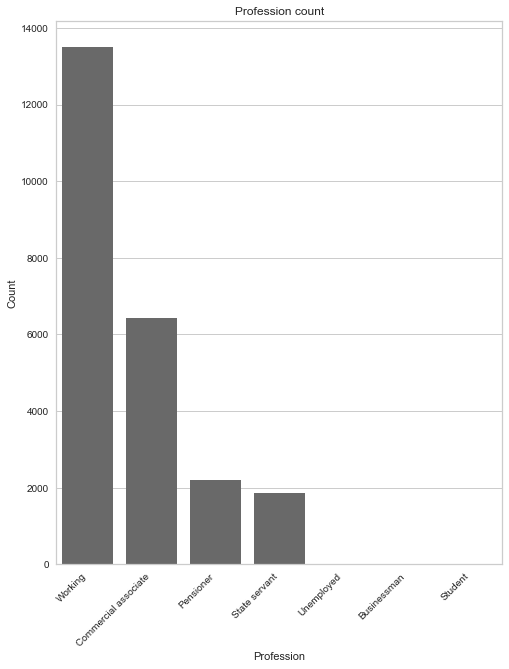

In [42]:
create_bar_plot(loan_amt_train_copy,'Profession')

Interpretation:
- Most applicants are currently working, the second most represented category is commercial associate.
- We also have a number of applicants that have pensioned and state servant.
- The most unrepresented category are the unemployed, businessman and student.

### 2.3.6 Type of employment

In [43]:
gen_info_feat(loan_amt_train_copy,'Type of Employment')

Description:
count        18228
unique          18
top       Laborers
freq          4495
Name: Type of Employment, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Laborers                4495      24.659864
Sales staff             2997      16.441738
Core staff              2605      14.291200
Managers                1996      10.950187
Drivers                 1273       6.983761
Accountants             1096       6.012728
High skill tech staff   1044       5.727452
Medicine staff           669       3.670178
Security staff           477       2.616853
Cooking staff            446       2.446785
Cleaning staff           283       1.552557
Private service staff    280       1.536098
Secretaries              132       0.724161
Low-skill Laborers       125       0.685758
Waiters/barmen staff     122       0.669300
Realty agents             73    

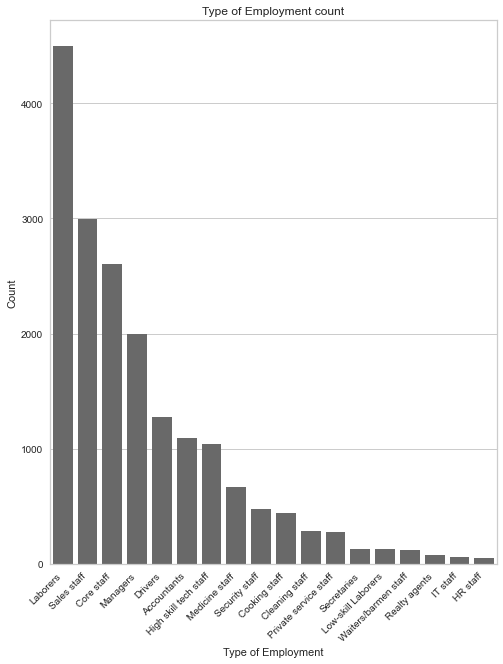

In [44]:
create_bar_plot(loan_amt_train_copy,'Type of Employment')

Interpretation:
- The most represented employment are laborers, sales staff, core staff and managers.
- The least represented employment are secretaries, low-skill laborers, waiters/barmen staff, realty agents, IT staff, HR staff.

### 2.3.7 Location

In [45]:
gen_info_feat(loan_amt_train_copy,'Location')

Description:
count          24000
unique             3
top       Semi-Urban
freq           17157
Name: Location, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
            Count  Frequency (%)
Semi-Urban  17157        71.4875
Rural        4320        18.0000
Urban        2523        10.5125


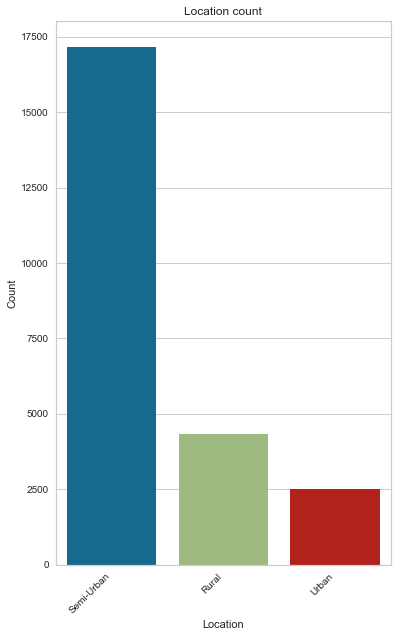

In [46]:
create_bar_plot(loan_amt_train_copy,'Location')

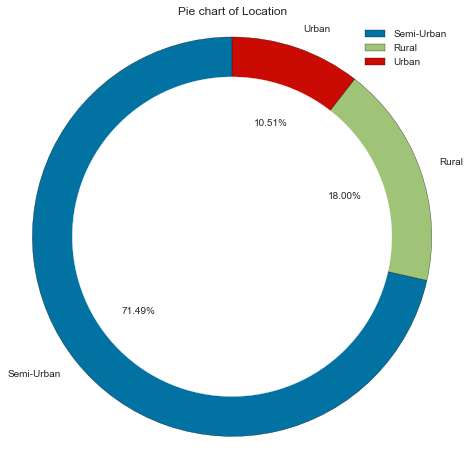

In [47]:
create_donnut_pie_chart(loan_amt_train_copy,'Location')

Interpretation:
- 7 out 10 applicants live in a semi-urban location
- Second most common location is the rural location
- Only 1 in 10 applicant live in an urban location

### 2.3.8 Loan Amount Request

In [48]:
gen_info_feat(loan_amt_train_copy,'Loan Amount Request (USD)')

Description:
count     24000.000000
mean      89075.615086
std       59637.687461
min        6048.240000
25%       41272.637500
50%       75326.655000
75%      120378.247500
max      621497.820000
Name: Loan Amount Request (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
1.2491353741072624


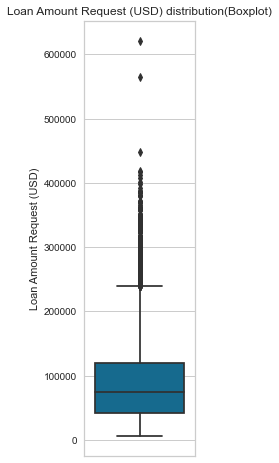

In [49]:
create_box_plot(loan_amt_train_copy, 'Loan Amount Request (USD)')

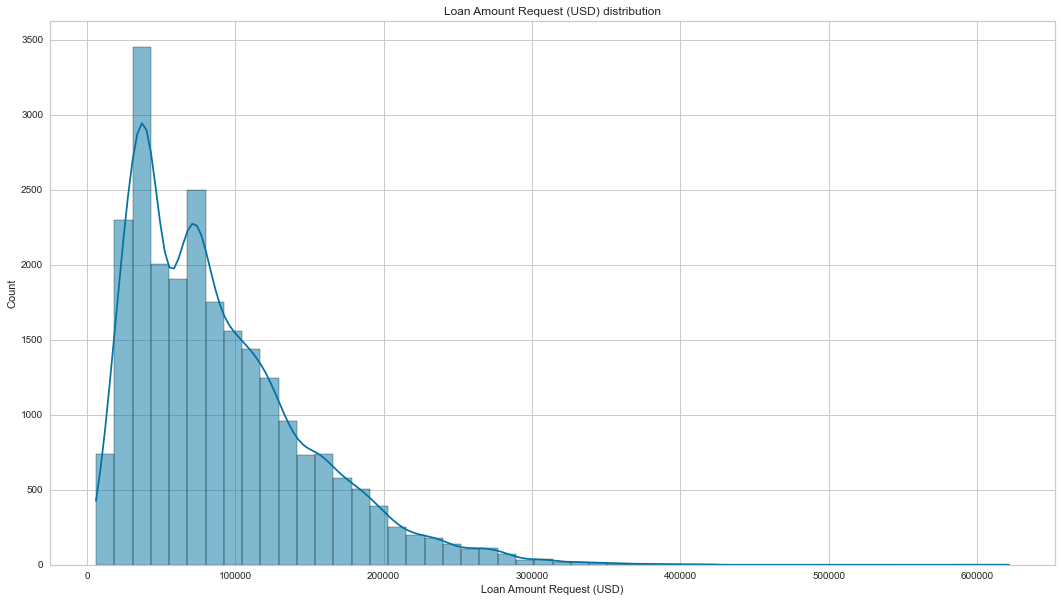

In [50]:
create_hist_plot(loan_amt_train_copy, 'Loan Amount Request (USD)')

Interpretation:
- The median of the loan amount request is $75326.655000
- We have quite a number of outliers in the loan amount request.
- The loan amount request distribution is positively skewed.

### 2.3.9 Current Loan Expenses

In [51]:
gen_info_feat(loan_amt_train_copy,'Current Loan Expenses (USD)')

Description:
count    23872.000000
mean       401.409325
std        241.893479
min       -999.000000
25%        248.932500
50%        375.275000
75%        521.215000
max       3419.660000
Name: Current Loan Expenses (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
-0.032881699548371904


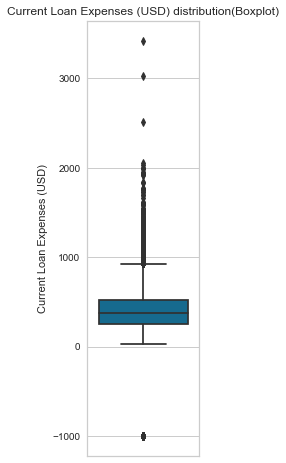

In [52]:
create_box_plot(loan_amt_train_copy, 'Current Loan Expenses (USD)')

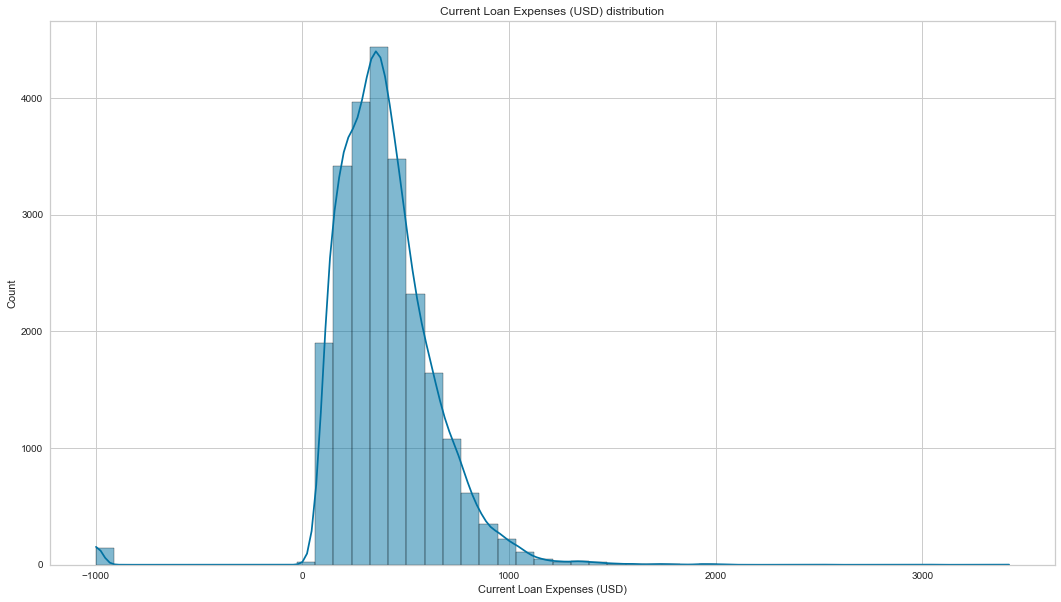

In [53]:
create_hist_plot(loan_amt_train_copy, 'Current Loan Expenses (USD)')

Interpretation:
- The mean current loan expenses is $375.275
- We have also some outliers
- The current loan expenses is positively skewed

### 2.3.10 Expense Type 1

In [54]:
gen_info_feat(loan_amt_train_copy,'Expense Type 1')

Description:
count     24000
unique        2
top           N
freq      15361
Name: Expense Type 1, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
N  15361      64.004167
Y   8639      35.995833


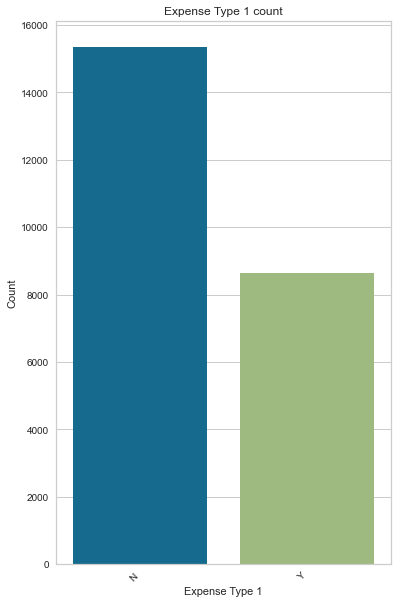

In [55]:
create_bar_plot(loan_amt_train_copy,'Expense Type 1')

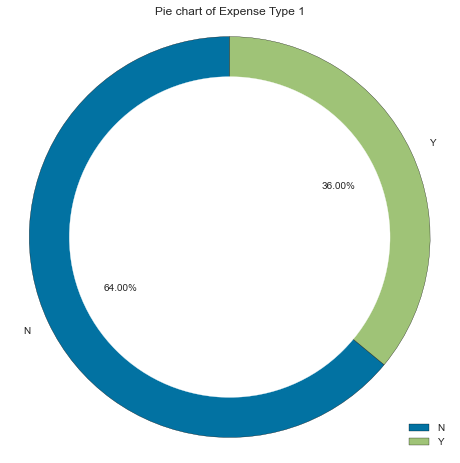

In [56]:
create_donnut_pie_chart(loan_amt_train_copy,'Expense Type 1')

Interpretation:
- More than half of applicants don't have the expenses type 1 on their loan.

### 2.3.11 Expense Type 2

In [57]:
gen_info_feat(loan_amt_train_copy,'Expense Type 2')

Description:
count     24000
unique        2
top           Y
freq      16116
Name: Expense Type 2, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
Y  16116          67.15
N   7884          32.85


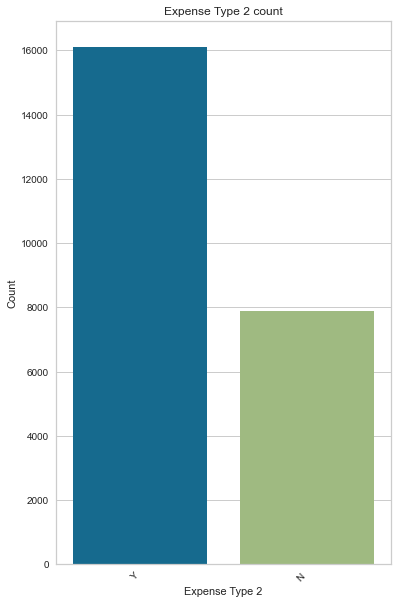

In [58]:
create_bar_plot(loan_amt_train_copy,'Expense Type 2')

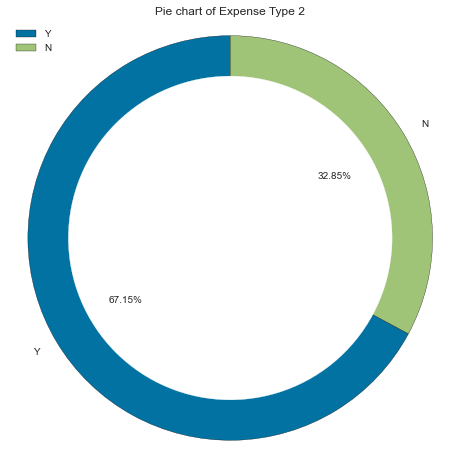

In [59]:
create_donnut_pie_chart(loan_amt_train_copy,'Expense Type 2')

Interpretation:
- The majority of applicants have expense type 2

### 2.3.12 Dependents

In [60]:
gen_info_feat(loan_amt_train_copy,'Dependents')

Description:
count    21983.000000
mean         2.250512
std          0.947379
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: Dependents, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
      Count  Frequency (%)
2.0   10471      47.632261
3.0    4568      20.779693
1.0    4447      20.229268
4.0    2160       9.825774
5.0     293       1.332848
6.0      37       0.168312
7.0       5       0.022745
8.0       1       0.004549
10.0      1       0.004549


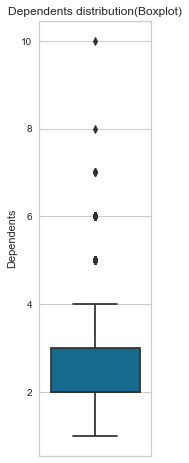

In [61]:
create_box_plot(loan_amt_train_copy, 'Dependents')

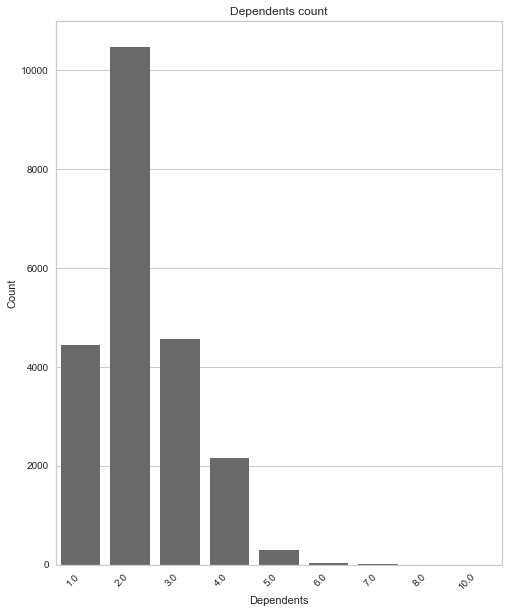

In [62]:
create_bar_plot(loan_amt_train_copy,'Dependents')

Interpretation:
- Most applicants have 2 dependents
- Then 1 and 3 dependents are the second most common
- Then 4 and 5 and so on

### 2.3.13 Credit Score

In [63]:
gen_info_feat(loan_amt_train_copy,'Credit Score')

Description:
count    22623.000000
mean       739.726632
std         72.271823
min        580.000000
25%        681.225000
50%        739.880000
75%        799.090000
max        896.260000
Name: Credit Score, dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
-0.021671118190646724


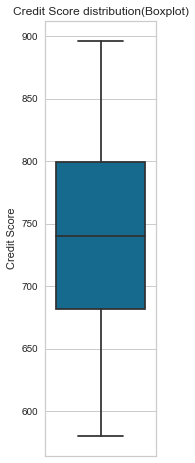

In [64]:
create_box_plot(loan_amt_train_copy, 'Credit Score')

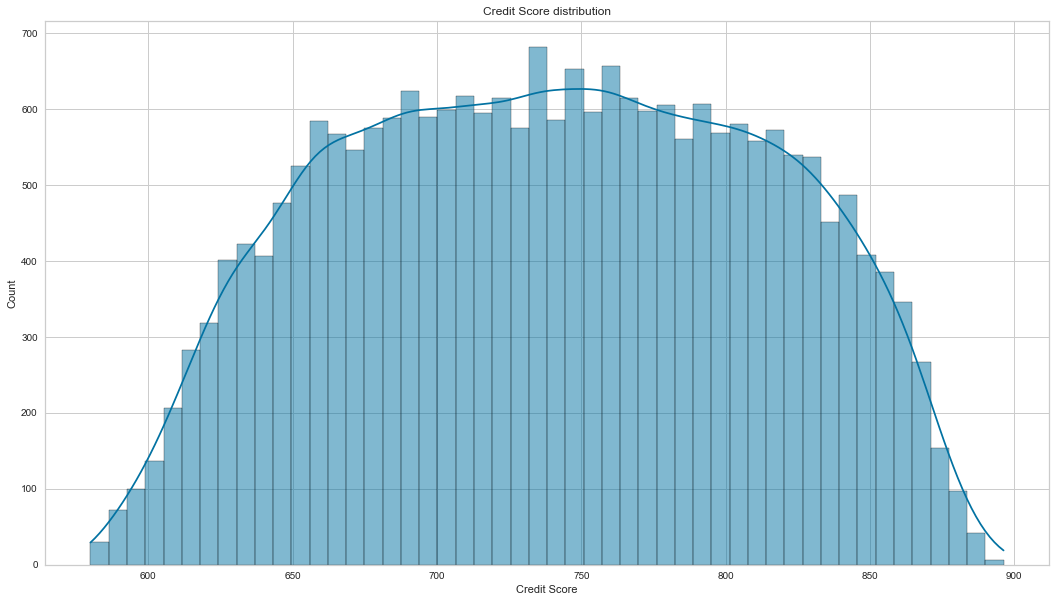

In [65]:
create_hist_plot(loan_amt_train_copy, 'Credit Score')

Interpretation:
- The mean and median of applicants's credit score is 739
- The credit score does not seems to be skewed but it is not normally distributed

### 2.3.14 Number of defaults

In [66]:
gen_info_feat(loan_amt_train_copy,'No. of Defaults')

Description:
count    24000.000000
mean         0.193875
std          0.395340
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: No. of Defaults, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  19347        80.6125
1   4653        19.3875


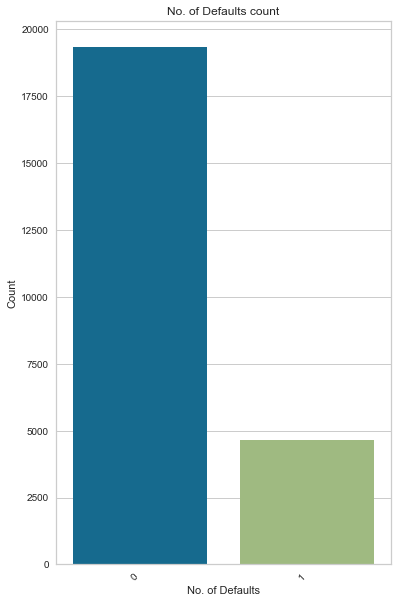

In [67]:
create_bar_plot(loan_amt_train_copy,'No. of Defaults')

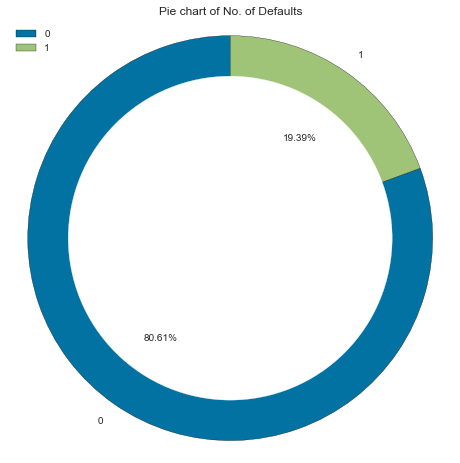

In [68]:
create_donnut_pie_chart(loan_amt_train_copy,'No. of Defaults')

Interpretation:
- 8 of 10 people don't have a any loan defaulted.

### 2.3.15 Has Active Credit Card

In [69]:
gen_info_feat(loan_amt_train_copy,'Has Active Credit Card')

Description:
count      22746
unique         3
top       Active
freq        7799
Name: Has Active Credit Card, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
             Count  Frequency (%)
Active        7799      34.287347
Inactive      7620      33.500396
Unpossessed   7327      32.212257


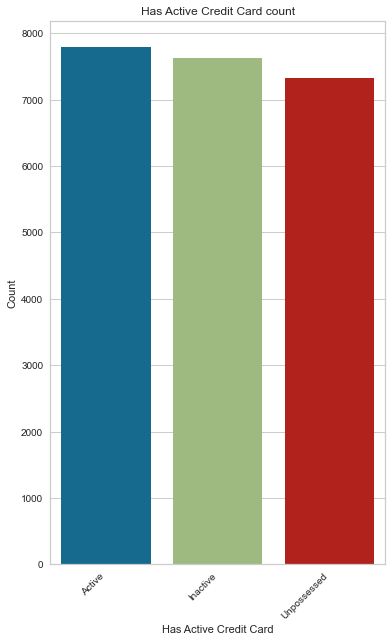

In [70]:
create_bar_plot(loan_amt_train_copy,'Has Active Credit Card')

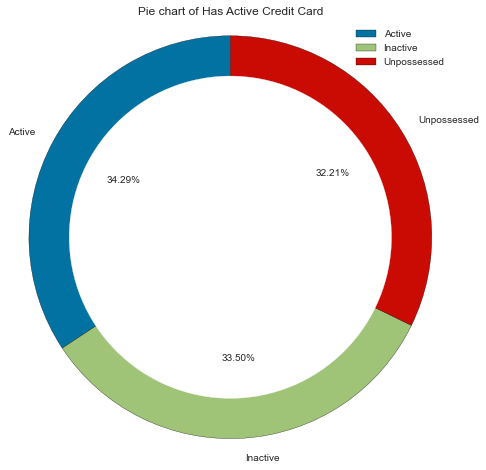

In [71]:
create_donnut_pie_chart(loan_amt_train_copy,'Has Active Credit Card')

Interpretation:
- We have almost an equal amount of people with an active, inactive and unpossessed credit card.

### 2.3.16 Property Age

In [72]:
gen_info_feat(loan_amt_train_copy,'Property Age')

Description:
count     55.164956
mean       7.030366
std        4.864649
min        1.036988
25%        4.525777
50%        6.108419
75%        8.471047
max      336.663326
Name: Property Age, dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
19.882898494886184


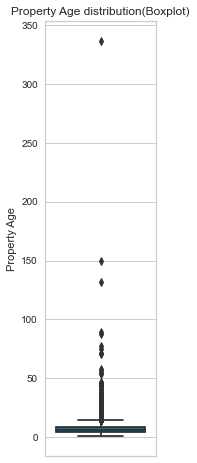

In [73]:
create_box_plot(loan_amt_train_copy, 'Property Age')

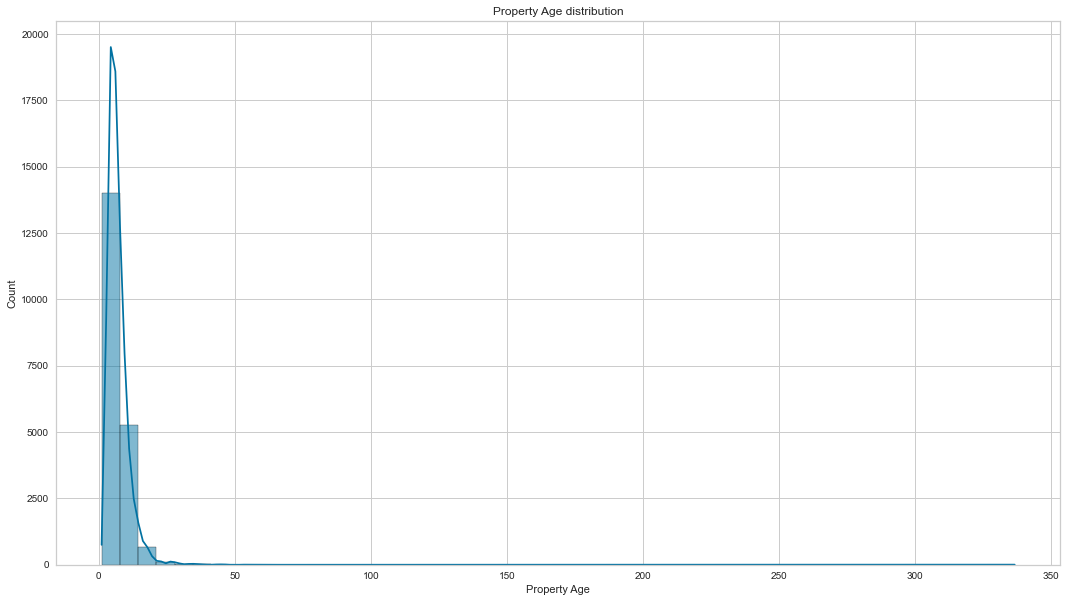

In [74]:
create_hist_plot(loan_amt_train_copy, 'Property Age')

Interpretation:
- Assuming that the property age is expressed in days, most of properties have a median age of 2231 days(6.1 years)
- The property age distribution is positively skewed


### 2.3.17 Property Type

In [75]:
gen_info_feat(loan_amt_train_copy,'Property Type')

Description:
count    24000.000000
mean         2.463708
std          1.121005
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: Property Type, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
1   6304      26.266667
2   6054      25.225000
3   5851      24.379167
4   5791      24.129167


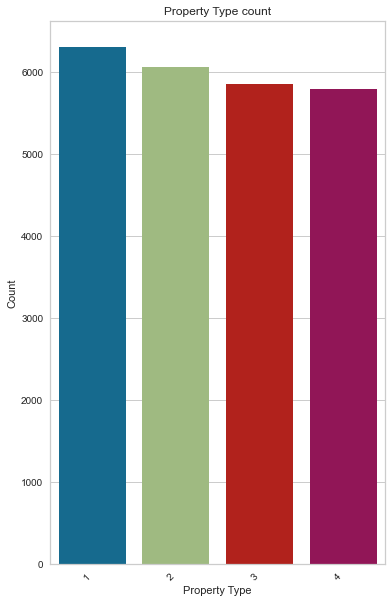

In [76]:
create_bar_plot(loan_amt_train_copy,'Property Type')

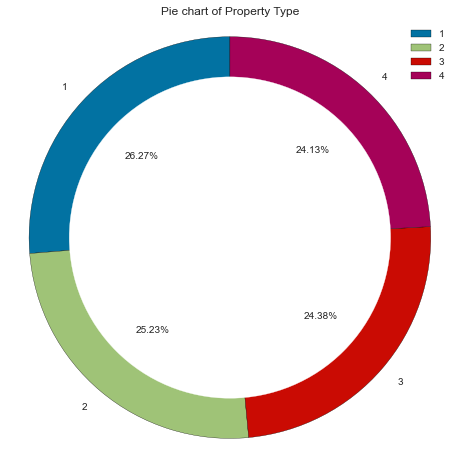

In [77]:
create_donnut_pie_chart(loan_amt_train_copy,'Property Type')

Interpretation:
- We have almost an equal amount of property types, each with 25%

### 2.3.18 Property Location

In [78]:
gen_info_feat(loan_amt_train_copy,'Property Location')

Description:
count          23727
unique             3
top       Semi-Urban
freq            8277
Name: Property Location, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
            Count  Frequency (%)
Semi-Urban   8277      34.884309
Rural        8060      33.969739
Urban        7390      31.145952


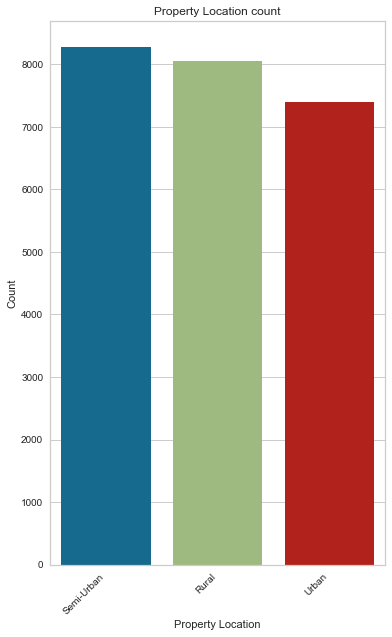

In [79]:
create_bar_plot(loan_amt_train_copy,'Property Location')

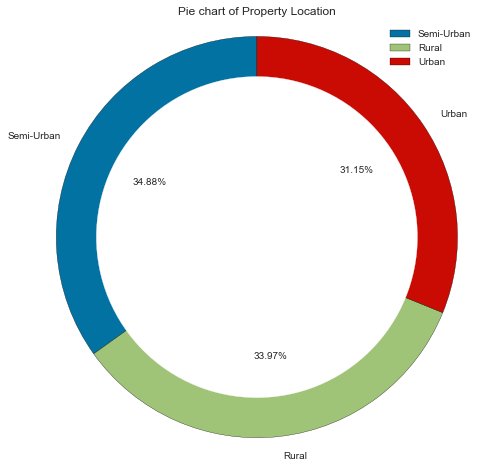

In [80]:
create_donnut_pie_chart(loan_amt_train_copy,'Property Location')

Interpretation:
- All the 3 property location are almost equally distributed at around 33%

### 2.3.19 Co-Applicant

In [81]:
gen_info_feat(loan_amt_train_copy,'Co-Applicant')

Description:
count    24000.000000
mean        -4.686333
std         74.227397
min       -999.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Co-Applicant, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
      Count  Frequency (%)
 1    20395      84.979167
 0     3472      14.466667
-999    133       0.554167


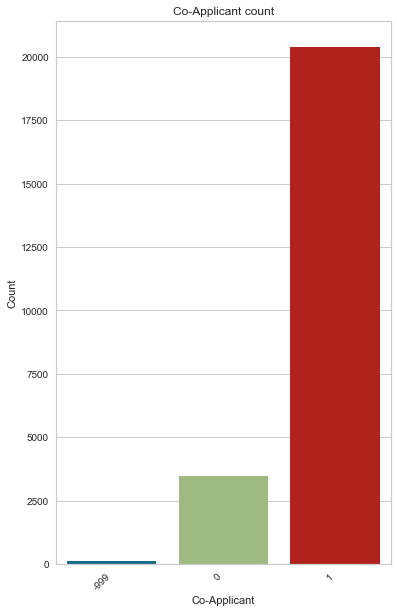

In [82]:
create_bar_plot(loan_amt_train_copy,'Co-Applicant')

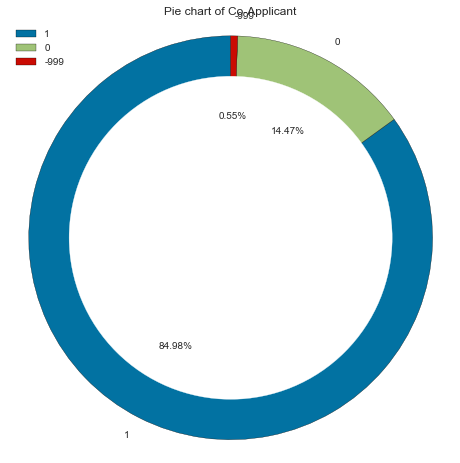

In [83]:
create_donnut_pie_chart(loan_amt_train_copy,'Co-Applicant')

Interpretation:
- Most of applicants have a co-applicants (~85%)
- 14% of applicants don't have a co-applicant
- The rest are unknown (~0.5%)

### 2.3.20 Property Price

In [84]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
gen_info_feat(loan_amt_train_copy,'Property Price')

Description:
count     24000.000
mean     132018.284
std       93566.244
min        -999.000
25%       60793.940
50%      110168.710
75%      179084.020
max     1077966.730
Name: Property Price, dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
1.3990671454033115


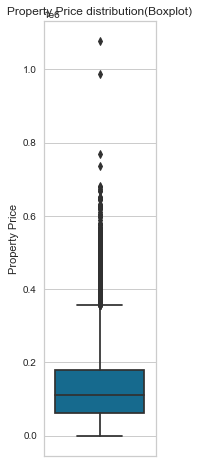

In [85]:
create_box_plot(loan_amt_train_copy, 'Property Price')

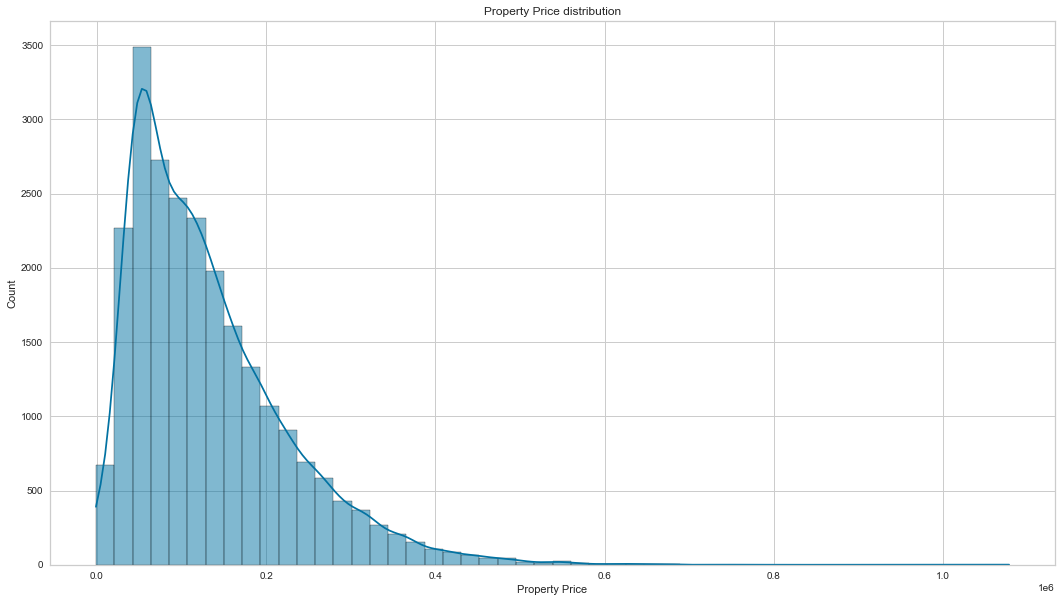

In [86]:
create_hist_plot(loan_amt_train_copy, 'Property Price')

Interpretation:
- The median property price is $110168.710
- We have quite a number of outliers
- The distribution of the property price is skewed to the right

### 2.3.21 Loan Sanction Amount

In [87]:
gen_info_feat(loan_amt_train_copy,'Loan Sanction Amount (USD)')

Description:
count    23725.000
mean     47680.600
std      48224.125
min       -999.000
25%          0.000
50%      35273.020
75%      74217.940
max     395368.740
Name: Loan Sanction Amount (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
1.2072630197126766


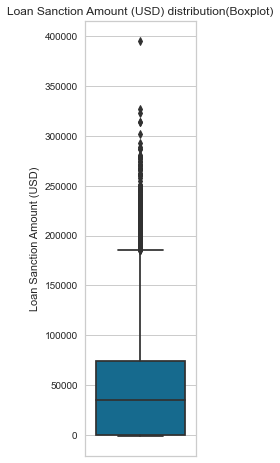

In [88]:
create_box_plot(loan_amt_train_copy, 'Loan Sanction Amount (USD)')

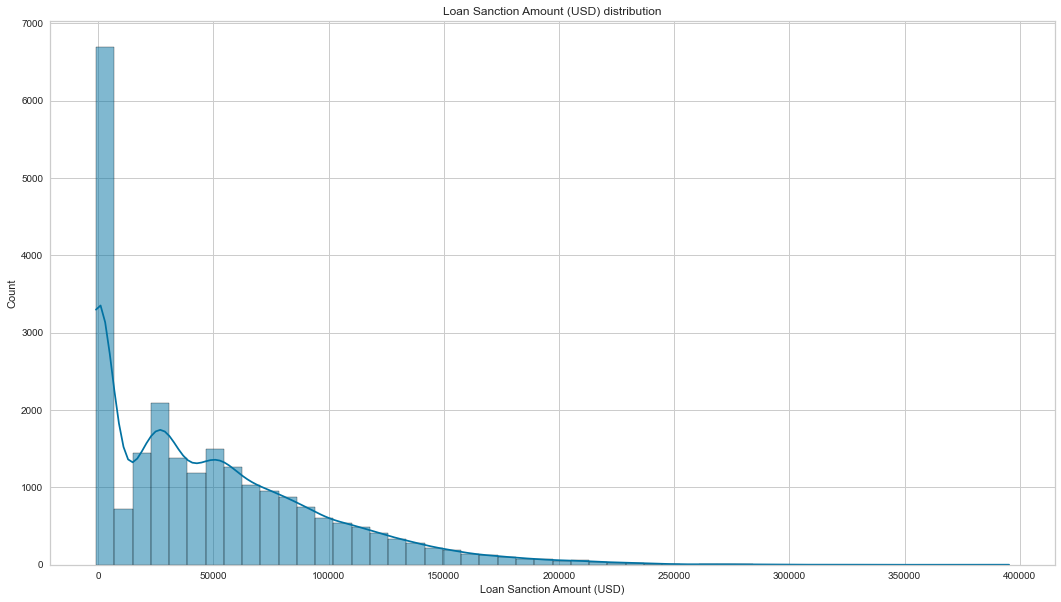

In [89]:
create_hist_plot(loan_amt_train_copy, 'Loan Sanction Amount (USD)')

Interpretation:
- The median loan sanction amount is $35273.020
- We have quite a number of outliers
- The distribution of the loan sanction amount is skewed to the right

## 2.4 Bivariate Analysis

### 2.4.1 Numerical vs numerical features (Correlation & scatter plots)

#### 2.4.1.1 Scatter plots

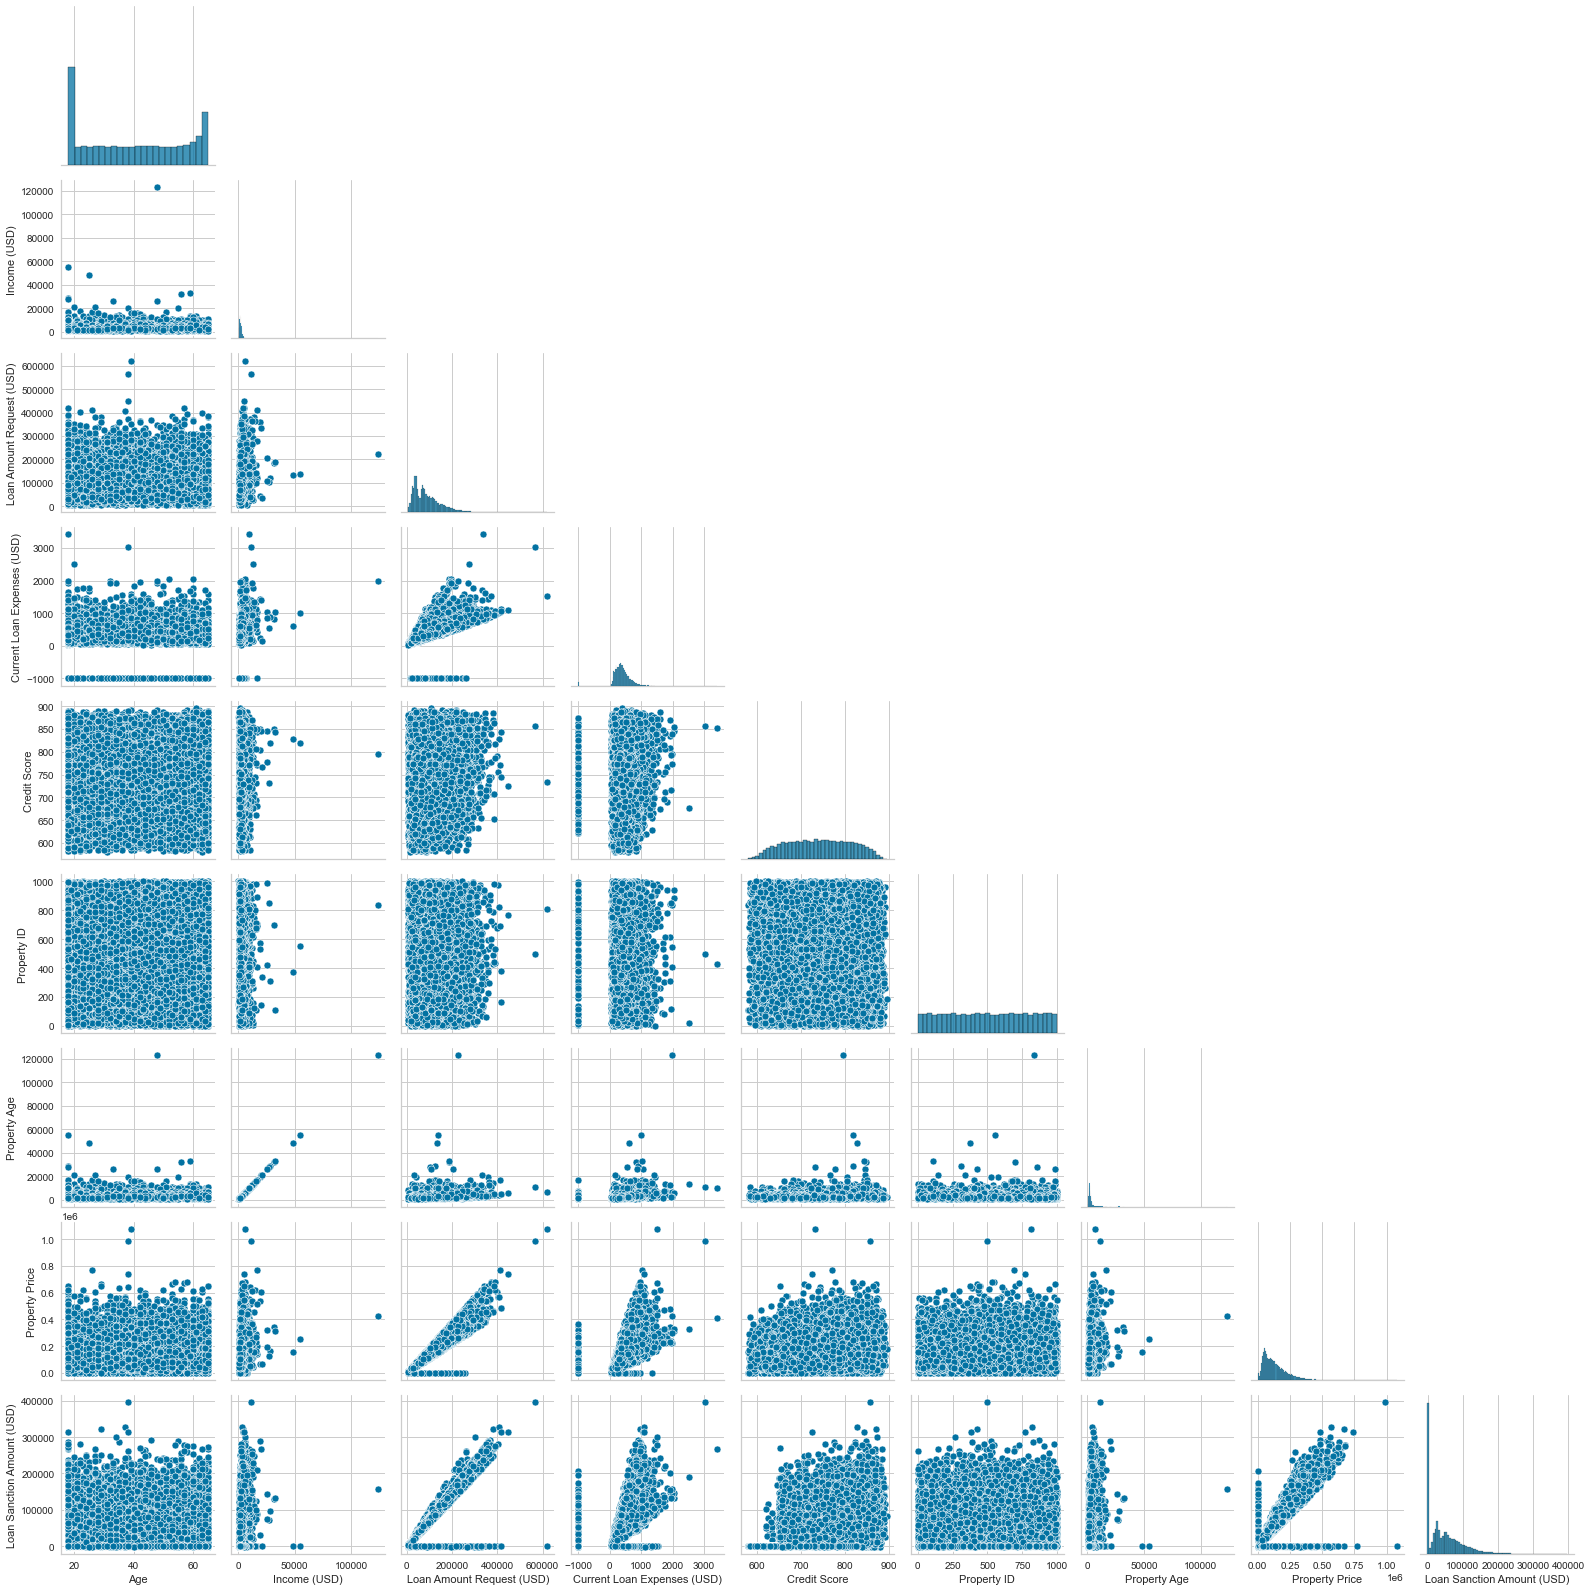

In [90]:
sns.pairplot(loan_amt_train_copy.drop(['Dependents','No. of Defaults','Property Type','Co-Applicant'],axis=1),corner=True)
plt.show()

Interpretation:
- There is a positive correlation between the loan amount request and the current loan expenses.
- There is also a perfect positive correlation between the income and the property age.
- There is a colleration between property price and loan amount request.
- There is a colleration between loan sanction amount and loan amount request.
- We also find a correlation between the property price and current loan expenses.
- There is a correlation between loan sanction amount and current loan expenses.
- There is a correlation between property price and loan sanction amount.

In [91]:
loan_amt_train_copy[['Loan Amount Request (USD)','Loan Sanction Amount (USD)']]

,Loan Amount Request (USD),Loan Sanction Amount (USD)
0,294604.890,235683.910
1,132263.080,0.000
2,112307.540,72999.900
3,24268.350,0.000
4,76342.040,57256.530
...,...,...
23995,122864.440,86005.110
23996,101151.000,65748.150
23997,91833.600,64283.520
23998,62065.250,43445.680


##### 2.4.1.1.1 Loan amount request vs current loan expenses

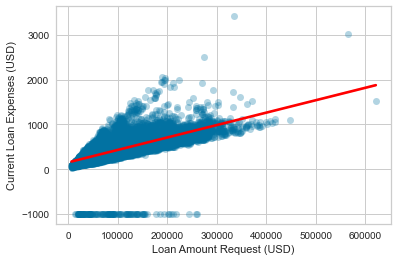

In [92]:
sns.regplot(x='Loan Amount Request (USD)',y='Current Loan Expenses (USD)',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- The more the loan amount requested, the more the current loan expenses.

##### 2.4.1.1.2 Income vs property age

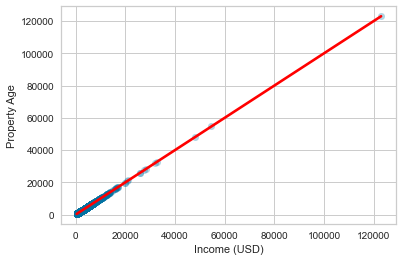

In [93]:
sns.regplot(x='Income (USD)',y='Property Age',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- We have a perfect correlation between the income and the property age. The more the income, the older the property.

##### 2.4.1.1.3 Loan amount request vs property price

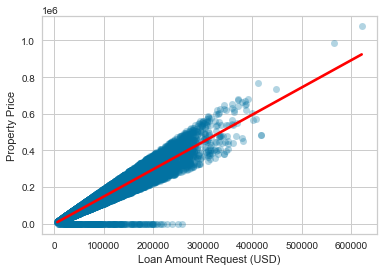

In [94]:
sns.regplot(x='Loan Amount Request (USD)',y='Property Price',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- The more amount of loan requested, the more expensive the property price.

##### 2.4.1.1.4 Loan amount request vs loan sanction amount

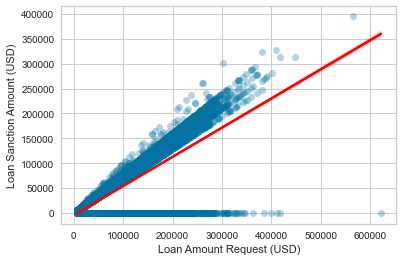

In [95]:
sns.regplot(x='Loan Amount Request (USD)',y='Loan Sanction Amount (USD)',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- The loan amount requested increase with the loan sanction amount

##### 2.4.1.1.5 Current loan expenses vs Property price

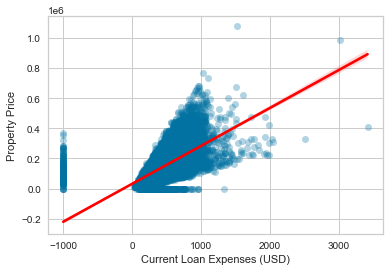

In [96]:
sns.regplot(x='Current Loan Expenses (USD)',y='Property Price',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- Loan expenses generally increases with the property price.

##### 2.4.1.1.6 Current loan expenses vs Loan sanctioned amount

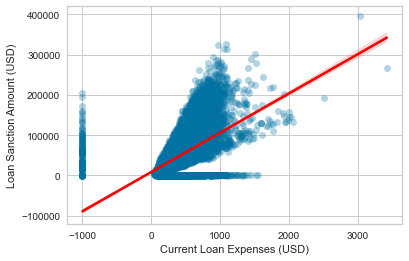

In [97]:
sns.regplot(x='Current Loan Expenses (USD)',y='Loan Sanction Amount (USD)',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- The loan expenses increase as the loan sanction amount increases.

##### 2.4.1.1.7 Property price vs loan sanction amount

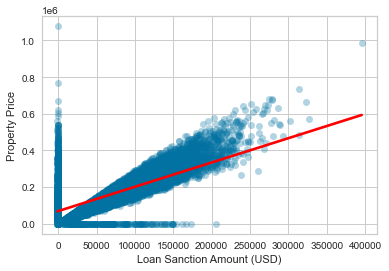

In [98]:
sns.regplot(x='Loan Sanction Amount (USD)',y='Property Price',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- Loan sanction amount and the property price are positively correlated.

#### 2.4.1.2 Correlation analysis

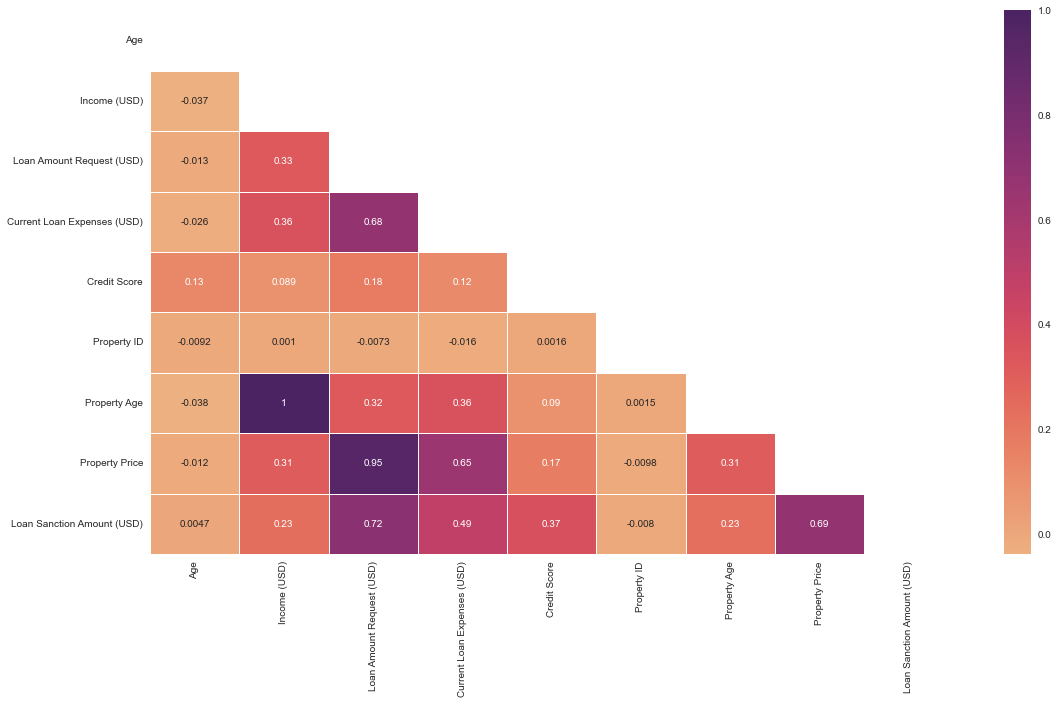

In [99]:
loan_amt_train_copy_corr = loan_amt_train_copy.drop(['Dependents','No. of Defaults','Property Type','Co-Applicant'],axis=1).corr()
# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(loan_amt_train_copy_corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(loan_amt_train_copy_corr, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()

Interpretation:
- Income is highly correlated with Property age
- Loan Amount Request is highly correlated with Property Price
- Loan Amount Request is highly correlated with Loan Sanction Amount
- Current Loan Expenses is correlated with Property Price
- Current Loan Expenses is correlated with Loan Sanction Amount
- Loan Sanction Amount is highly correlated with Property Price


In [100]:
loan_amt_train_copy.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')

In [101]:
loan_amt_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  24000 non-null  object 
 1   Name                         24000 non-null  object 
 2   Gender                       23954 non-null  object 
 3   Age                          24000 non-null  int64  
 4   Income (USD)                 20352 non-null  float64
 5   Income Stability             22676 non-null  object 
 6   Profession                   24000 non-null  object 
 7   Type of Employment           18228 non-null  object 
 8   Location                     24000 non-null  object 
 9   Loan Amount Request (USD)    24000 non-null  float64
 10  Current Loan Expenses (USD)  23872 non-null  float64
 11  Expense Type 1               24000 non-null  object 
 12  Expense Type 2               24000 non-null  object 
 13  Dependents      

#### 2.4.2 Numerical vs categorical features (ANOVA)

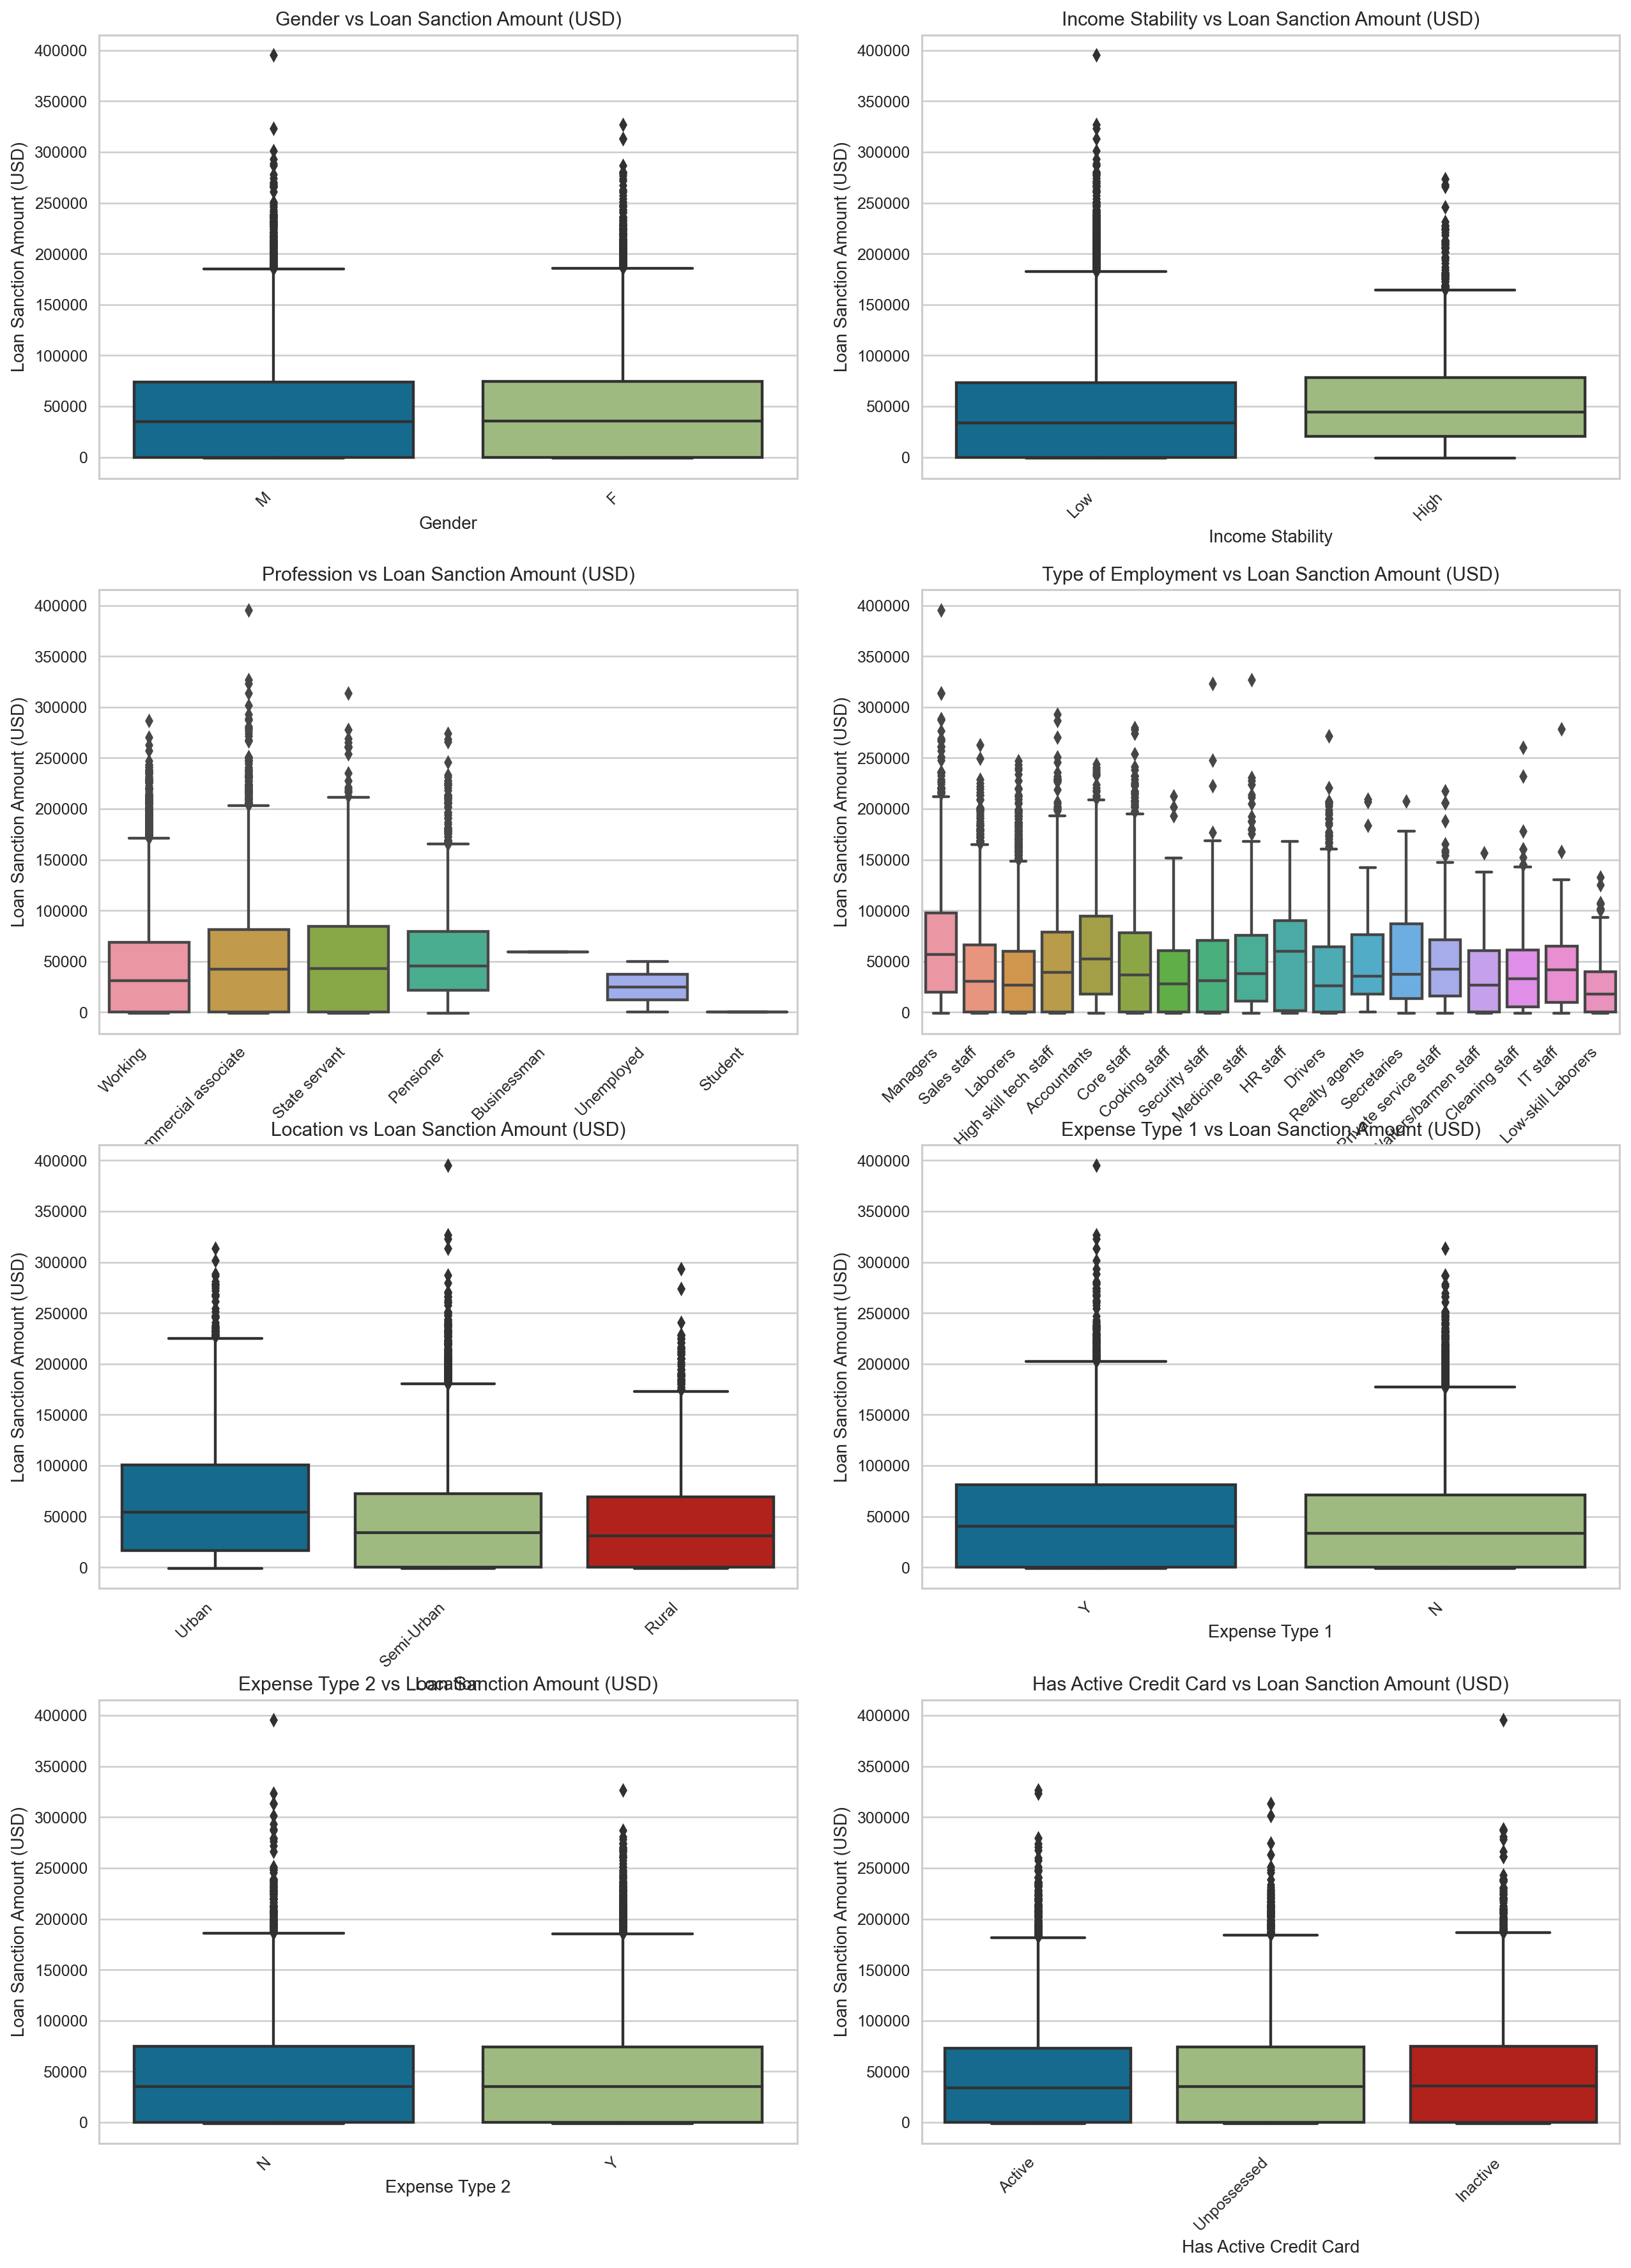

In [102]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['Gender','Income Stability','Profession','Type of Employment','Location','Expense Type 1','Expense Type 2','Has Active Credit Card','Property Location']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=loan_amt_train_copy[cat_features[cat_ft_count]],y=loan_amt_train_copy['Loan Sanction Amount (USD)'])
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs Loan Sanction Amount (USD)")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Loan Sanction Amount (USD)')
            cat_ft_count += 1
    break

Interpretation:
- People with high income stability were given a high loan sanction amount
- Managers, HR staff and accounts received a median loan sanction amount of $5000
- People who live in urban area received the highest loan sanction amount

# 3. Prepare the data

## 3.1 Transformations to be done on each feature

Customer ID:
- Drop the feature

Name:
- Drop the feature


Gender:
- One hot encoding
- Missing value(Replace with the mode)


Age:
-	Min-max enc

Income:
-	Min-max enc
-	Outliers handler
-	Missing value (Replace with median)
-   Fix skewness

Income stability:
-	One hot encoding
-	Missing value (replace with the mode)

Profession:
-	One hot encoding
-   Drop the rows with the least frequent profession (Student, Businessman, Unemployed)

Type of employment
-	Drop the feature

Location:
-	One hot encoding

Loan amount request:
-	Min-max enc
-	Outliers handler
-   Fix skewness

Current loan expenses:
-	-999 handler
-	Min-max enc
-	Outliers handler
-	Missing value (replace with median)
-   Fix skewness

Expenses type 1
-	One hot encoding

Expenses type 2
-	One hot encoding


Dependents:
-	Outliers handler
-   Missing value (replace with mode)

Credit score:
-	Min-max enc
-	Missing value (replace with the mean/median)

Number of default:
-	Nothing to do

Has an active credit card:
-	One hot encoding
-	Missing value (replace with mode)

Property ID:
-	Drop feature

Property age:
-	Min-max enc
-	Outlier handler
- 	Missing value (replace with the median)
-   Fix skewness

Property type:
-	Nothing

Property loc:
-	One hot encoding
-	Missing value (replace with mode)

Co- applicant:
-	-999 handler

Property price:
-	Min max
-	Outliers handler
-   Fix skewness
-   -999 handler

Loan sanction amount:
-	Missing value (Drop the rows)
-   -999 handler



## 3.2 Data Cleaning

### 3.2.1 Outliers imputer

In [103]:
class OutlierImputer(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Dependents', 'Property Age', 'Property Price']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 1.5 * IQR)) | (df[self.feat_with_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.2.2 Missing values imputer

In [104]:
class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, mode_imputed_ft = ['Gender','Income Stability','Dependents','Has Active Credit Card','Property Location'], median_imputed_ft = ['Income (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property Age']):
        self.mode_imputed_ft = mode_imputed_ft
        self.median_imputed_ft = median_imputed_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.mode_imputed_ft + self.median_imputed_ft).issubset(df.columns)):
            # drop missing values in the target feature
            df.dropna(inplace=True, axis=0, subset=['Loan Sanction Amount (USD)'])
            # impute missing values with mode
            for ft in self.mode_imputed_ft:
                the_mode = df[ft].mode()[0]
                df[ft] = df[ft].fillna(the_mode)
            # impute missing values with median
            for ft in self.median_imputed_ft:
                the_median = df[ft].median()
                df[ft] = df[ft].fillna(the_median)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.2.3 Remove less frequent professions

In [105]:
class DropUncommonProfession(BaseEstimator, TransformerMixin):
    def __init__(self,profession_list = ['Student','Unemployed','Businessman']):
        self.profession_list = profession_list
    def fit(self,df):
        return self
    def transform(self,df):
        if ('Profession' in df.columns):
            # only keep the professions that are not in the profession_list
            df = df[~df['Profession'].isin(self.profession_list)]
            return df
        else:
            print("Profession feature is not in the dataframe")
            return df

## 3.3 Feature selection

### 3.3.1 Feature drop

In [106]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['Customer ID','Name','Type of Employment','Property ID']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

## 3.4 Feature transformation

### 3.4.1 -999 Value imputer

In [107]:
class ValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_999_val=['Co-Applicant', 'Current Loan Expenses (USD)', 'Loan Sanction Amount (USD)', 'Property Price']):
        self.feat_with_999_val = feat_with_999_val
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_999_val).issubset(df.columns)):
            for ft in self.feat_with_999_val:
                # replace any occurance of -999.000 with 0
                df[ft].replace(-999.000,0,inplace=True,regex=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.2 Min-Max scaling (with feature's names)

In [108]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property Age', 'Property Price']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.3 One hot encoding (with feature's name)

In [109]:
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Profession', 'Location', 'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location', 'Income Stability']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # function to one hot encode the features in one_hot_enc_ft
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.4 Skewness Handler

In [110]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_skewness=['Income (USD)','Loan Amount Request (USD)','Current Loan Expenses (USD)','Property Age']):
        self.col_with_skewness = col_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.col_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.col_with_skewness] = np.cbrt(df[self.col_with_skewness])
            return df
        else:
            print('One or more skewed columns are not found')
            return df

## 3.5 Data Preprocessing

In [111]:
def full_pipeline(df):
    pipeline = Pipeline([
        ('outlier remover', OutlierImputer()),
        ('drop uncommon profession', DropUncommonProfession()),
        ('missing value imputer', MissingValueImputer()),
        ('drop features', DropFeatures()),
        ('-999 value imputer', ValueImputer()),
        ('skewness handler', SkewnessHandler()),
        ('min max scaler', MinMaxWithFeatNames()),
        ('one hot encoder', OneHotWithFeatNames())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [112]:
pd.options.mode.chained_assignment = None
loan_amt_train_copy_prep = full_pipeline(loan_amt_train_copy)

In [113]:
loan_amt_train_copy_prep

,Gender_F,Gender_M,Profession_Commercial associate,Profession_Pensioner,Profession_State servant,Profession_Working,Location_Rural,Location_Semi-Urban,Location_Urban,Expense Type 1_N,Expense Type 1_Y,Expense Type 2_N,Expense Type 2_Y,Has Active Credit Card_Active,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Rural,Property Location_Semi-Urban,Property Location_Urban,Income Stability_High,Income Stability_Low,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
1,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.383,0.554,0.747,0.721,1.000,0.209,1,0.554,3,1,0.702,0.000
2,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.723,0.554,0.685,0.752,1.000,0.400,0,0.554,2,1,0.443,72999.900
3,1.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.554,0.245,0.351,2.000,0.190,0,0.554,2,1,0.085,0.000
4,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.569,0.552,0.853,2.000,0.808,0,0.569,3,1,0.399,57256.530
5,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.694,0.625,0.934,2.000,0.573,0,0.694,2,1,0.408,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.511,0.523,0.544,0.795,3.000,0.066,1,0.523,2,1,0.386,0.000
23995,1.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.021,0.554,0.718,0.590,1.000,0.676,1,0.554,2,1,0.551,86005.110
23997,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.412,0.613,0.564,2.000,0.677,0,0.412,4,1,0.308,64283.520
23998,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.383,0.554,0.488,0.638,3.000,0.462,0,0.554,4,1,0.201,43445.680


In [114]:
X_loan_amt_train_prep, y_loan_amt_train_prep = loan_amt_train_copy_prep.loc[:, loan_amt_train_copy_prep.columns != 'Loan Sanction Amount (USD)'], loan_amt_train_copy_prep['Loan Sanction Amount (USD)']

In [115]:
X_loan_amt_train_prep

,Gender_F,Gender_M,Profession_Commercial associate,Profession_Pensioner,Profession_State servant,Profession_Working,Location_Rural,Location_Semi-Urban,Location_Urban,Expense Type 1_N,Expense Type 1_Y,Expense Type 2_N,Expense Type 2_Y,Has Active Credit Card_Active,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Rural,Property Location_Semi-Urban,Property Location_Urban,Income Stability_High,Income Stability_Low,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price
1,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.383,0.554,0.747,0.721,1.000,0.209,1,0.554,3,1,0.702
2,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.723,0.554,0.685,0.752,1.000,0.400,0,0.554,2,1,0.443
3,1.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.554,0.245,0.351,2.000,0.190,0,0.554,2,1,0.085
4,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.569,0.552,0.853,2.000,0.808,0,0.569,3,1,0.399
5,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.694,0.625,0.934,2.000,0.573,0,0.694,2,1,0.408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.511,0.523,0.544,0.795,3.000,0.066,1,0.523,2,1,0.386
23995,1.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.021,0.554,0.718,0.590,1.000,0.676,1,0.554,2,1,0.551
23997,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.412,0.613,0.564,2.000,0.677,0,0.412,4,1,0.308
23998,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.383,0.554,0.488,0.638,3.000,0.462,0,0.554,4,1,0.201


In [116]:
y_loan_amt_train_prep

1           0.000
2       72999.900
3           0.000
4       57256.530
5           0.000
           ...   
23994       0.000
23995   86005.110
23997   64283.520
23998   43445.680
23999   55597.380
Name: Loan Sanction Amount (USD), Length: 21477, dtype: float64

# 4. Short-list promising models

## 4.1 Model training

In [117]:
Regressors = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Elastic Net Regression': ElasticNet(random_state=42),
    'KNN Regression': KNeighborsRegressor(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42),
    'AdaBoost Regression': AdaBoostRegressor(random_state=42),
    'Bagging Regression': BaggingRegressor(random_state=42),
    'Extra Trees Regression': ExtraTreesRegressor(random_state=42),
    'Kernel Ridge Regression': KernelRidge(),
    'Bayesian Ridge Regression': BayesianRidge(),
    'Stochastic Gradient Descent Regression': SGDRegressor(random_state=42),
    'SVM Regression': SVR(),
    'Gaussian Process Regression': GaussianProcessRegressor(random_state=42),
    'Neural Network Regression': MLPRegressor(random_state=42)
}

In [118]:
def fit_score_model(model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep):
    rmse_scores_path = Path('saved_models/{0}/rmse_{0}'.format(model_name))
    try:
        #check if the file exists
        rmse_scores_path.resolve(strict=True)
    except FileNotFoundError:
        scores = cross_val_score(model, X_loan_amt_train_prep, y_loan_amt_train_prep, cv=3, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)
        print('Score: {}'.format(rmse_scores))
        print('Mean score: {}'.format(rmse_scores.mean()))
        print('Standard deviation: {}'.format(rmse_scores.std()))
        joblib.dump(rmse_scores, 'saved_models/{0}/rmse_{0}'.format(model_name))
    else:
        rmse_scores = joblib.load('saved_models/{0}/rmse_{0}'.format(model_name))
        print('Score: {}'.format(rmse_scores))
        print('Mean score: {}'.format(rmse_scores.mean()))
        print('Standard deviation: {}'.format(rmse_scores.std()))

In [119]:
def folder_check_model(model_name):
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_models/{}/'.format(model_name)):
        os.makedirs('saved_models/{}/'.format(model_name))

In [120]:
# loop over all the models
for model_name, model in Regressors.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check_model(model_name)
    # fit and score the model
    fit_score_model(model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)





----------------------  Linear Regression  ----------------------


Score: [26530.61968289 26866.93583927 25607.67510933]
Mean score: 26335.076877162657
Standard deviation: 532.3608664226397




----------------------  Ridge Regression  ----------------------


Score: [26524.35707616 26848.35019923 25580.67284414]
Mean score: 26317.793373179982
Standard deviation: 537.7439859852428




----------------------  Lasso Regression  ----------------------


Score: [26523.91704521 26851.2967308  25577.31212505]
Mean score: 26317.508633684618
Standard deviation: 540.1928780128102




----------------------  Elastic Net Regression  ----------------------


Score: [36939.77336002 36710.85073886 36574.30668094]
Mean score: 36741.643593275316
Standard deviation: 150.78157113870196




----------------------  KNN Regression  ----------------------


Score: [36815.69436198 36947.24397619 36587.82264699]
Mean score: 36783.586995053425
Standard deviation: 148.47914607431136




-------------------

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Score: [34673.86952085 34679.0545305  34476.12695546]
Mean score: 34609.683668938094
Standard deviation: 94.46257765889726


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


## 4.2 Top 4 models

- Random Forest Regressor
- Gradient Boosting Regressor
- Extra Trees Regression
- Bagging Regression

# 5. Fine tuning the model

In [121]:
def feat_importance(model_trn, model_name):
    # change xtick font size
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    # top 10 most predictive features
    top_10_feat = FeatureImportances(model_trn, relative=False, topn=10)
    # top 10 least predictive features
    bottom_10_feat = FeatureImportances(model_trn, relative=False, topn=-10)
    #change the figure size
    plt.figure(figsize=(10, 4))
    #change x label font size
    plt.xlabel('xlabel', fontsize=14)
    # Fit to get the feature importances
    top_10_feat.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
    # show the plot
    top_10_feat.show()
    print('\n')
    plt.figure(figsize=(10, 4))
    plt.xlabel('xlabel', fontsize=14)
    # Fit to get the feature importances
    bottom_10_feat.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
    # show the plot
    bottom_10_feat.show()
    print('\n')

In [122]:
def shap_ft_importance(model_name, model,X_loan_amt_train_prep,y_loan_amt_train_prep):
    # get the model
    model = model
    # fit the model
    model.fit(X_loan_amt_train_prep,y_loan_amt_train_prep)
    # load JS visualization code to notebook
    shap.initjs()
    # get the shap values
    shap_values = shap.TreeExplainer(model).shap_values(X_loan_amt_train_prep)
    # get the feature importance
    shap_ft_importance = shap.summary_plot(shap_values,features=X_loan_amt_train_prep,feature_names=X_loan_amt_train_prep.columns, show=False)
    plt.savefig('saved_final_models/{0}/shap_ft_importance_{0}.png'.format(model_name))


In [123]:
def train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep):
    trained_model_path = Path('saved_final_models/{0}/trained_{0}'.format(model_name))
    try:
        trained_model_path.resolve(strict=True)
    except FileNotFoundError:
        #train the model with the best parameters
        best_model_trn = best_model.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
        joblib.dump(best_model_trn, 'saved_final_models/{0}/trained_{0}'.format(model_name))
    else:
        best_model_trn = joblib.load('saved_final_models/{0}/trained_{0}'.format(model_name))
    return best_model_trn

In [124]:
def fine_tune_model(model_name,model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep):
    folder_check_model(model_name)
    rand_search_path = Path('saved_final_models/{0}/rand_search_{0}'.format(model_name))
    try:
        rand_search_path.resolve(strict=True)
    except FileNotFoundError:
        rand_search = RandomizedSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=5, return_train_score=True)
        rand_search.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
        joblib.dump(rand_search, 'saved_final_models/{0}/rand_search_{0}'.format(model_name))
        best_model = rand_search.best_estimator_
        rand_res = rand_search.cv_results_
        print('*'*50)
        for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
            print(np.sqrt(-mean_score), params)
    else:
        rand_search = joblib.load('saved_final_models/{0}/rand_search_{0}'.format(model_name))
        best_model = rand_search.best_estimator_
        rand_res = rand_search.cv_results_
        for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
            print(np.sqrt(-mean_score), params)
    return best_model

In [125]:
def folder_check_model(model_name):
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_final_models/{}/'.format(model_name)):
        os.makedirs('saved_final_models/{}/'.format(model_name))

## 5.1 Random Forest Regression

In [126]:
parameters = [
    {'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
]

In [127]:
rand_forest_dict = {'Random Forest Regression': RandomForestRegressor(random_state=42)}

In [128]:
model_name, model = list(rand_forest_dict.keys())[0], list(rand_forest_dict.values())[0]

In [129]:
best_model = fine_tune_model(model_name, model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


**************************************************
20768.8473010948 {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': True}
21085.005907425737 {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
21133.32145829293 {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
24770.196255456216 {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}
20486.516590643452 {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
21083.696059449463 {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}
21299.583231851735 {'n_estimators': 1400, 'min_samples_

In [130]:
best_rand_for_trn = train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


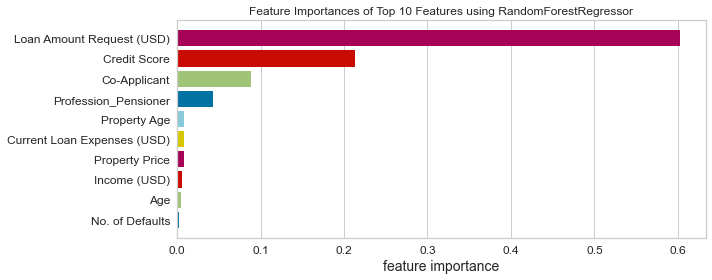

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


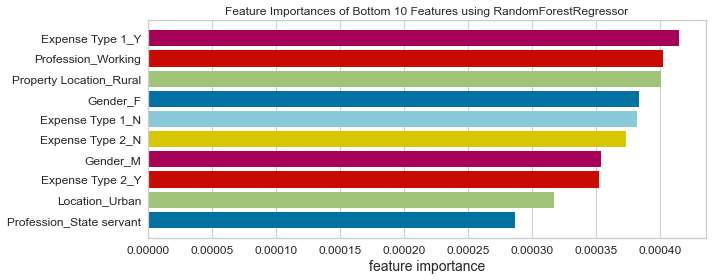

In [131]:
feat_importance(best_rand_for_trn, model_name)

## 5.2 Gradient Boosting Regression

In [132]:
parameters = [
    {
    'n_estimators':[5,50,100,250,500,1000,1500,2000],
    'max_depth':[1,3,5,7,9],
    'loss':['squared_error', 'absolute_error','huber','quantile'],
    'learning_rate':[0.0001,0.001,0.01,0.1,1,10],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True),
    'max_features':['auto','sqrt'],
    }
]

In [133]:
grad_boost_dict = {'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42)}

In [134]:
model_name, model = list(grad_boost_dict.keys())[0], list(grad_boost_dict.values())[0]

In [135]:
best_model = fine_tune_model(model_name, model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


overflow encountered in square


**************************************************
40544.86652246472 {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 0.4, 'max_features': 'auto', 'max_depth': 1, 'loss': 'huber', 'learning_rate': 0.0001}
36891.102548955154 {'n_estimators': 1500, 'min_samples_split': 5, 'min_samples_leaf': 0.4, 'max_features': 'sqrt', 'max_depth': 1, 'loss': 'absolute_error', 'learning_rate': 0.001}
27501.517987402185 {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 0.2, 'max_features': 'sqrt', 'max_depth': 7, 'loss': 'squared_error', 'learning_rate': 0.1}
25067.392475997334 {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 0.1, 'max_features': 'sqrt', 'max_depth': 9, 'loss': 'huber', 'learning_rate': 1}
27986.70014571472 {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 0.2, 'max_features': 'auto', 'max_depth': 9, 'loss': 'huber', 'learning_rate': 0.1}
30532.870254040183 {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf'

In [136]:
best_grad_boost_trn = train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


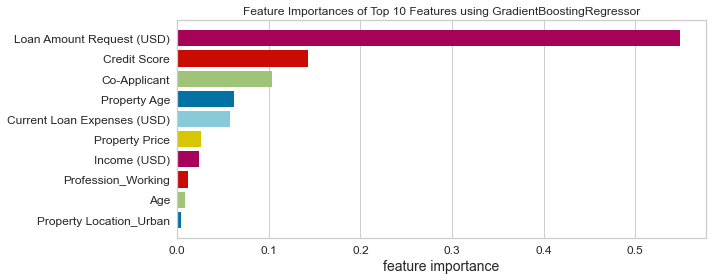

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


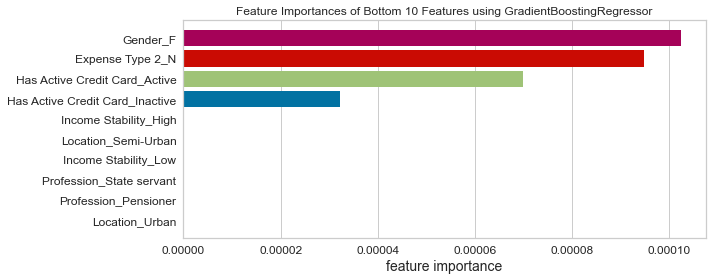

In [137]:
feat_importance(best_grad_boost_trn, model_name)

## 5.3 Extra Trees Regression

In [138]:
n_samples = X_loan_amt_train_prep.shape[0]
n_features = X_loan_amt_train_prep.shape[1]

parameters = [
    {
    'n_estimators': [10, 50, 100, 500, 1000, 2000],
    'max_depth': [None, 2,5,],
    'min_samples_split': [2, 0.5, n_samples//2, ],
    'min_samples_leaf': [1, 0.5, n_samples//2, ],
    'criterion': ['squared_error', 'absolute_error'],
    'max_features': [None, 'sqrt', 'auto', 'log2', 0.3, 0.5, n_features//2],
    'bootstrap':[True, False]
    }
]

In [139]:
extra_trees_dict = {'Extra Trees Regression': ExtraTreesRegressor(random_state=42)}

In [140]:
model_name, model = list(extra_trees_dict.keys())[0], list(extra_trees_dict.values())[0]

In [141]:
folder_check_model(model_name)

In [142]:
best_model = fine_tune_model(model_name, model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
**************************************************
41994.82994678943 {'n_estimators': 100, 'min_samples_split': 10738, 'min_samples_leaf': 0.5, 'max_features': 'auto', 'max_depth': 5, 'criterion': 'absolute_error', 'bootstrap': True}
40801.019377250625 {'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 10738, 'max_features': 'sqrt', 'max_depth': 2, 'criterion': 'squared_error', 'bootstrap': True}
40801.61522714166 {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 10738, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'squared_error', 'bootstrap': True}
40801.61522714166 {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 10738, 'max_features': 0.5, 'max_depth': None, 'criterion': 'squared_error', 'bootstrap': True}
22592.177241260182 {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 5, 'criterion': 'squared_error', 'bootst

In [143]:
best_extra_tree_trn = train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names


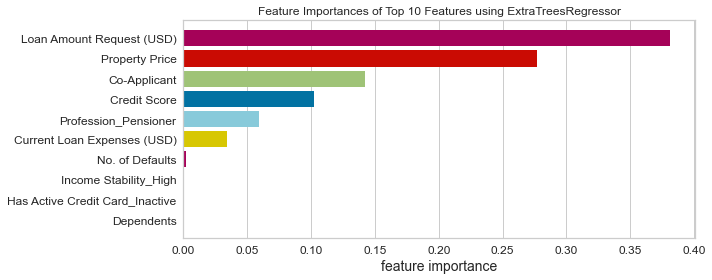

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names


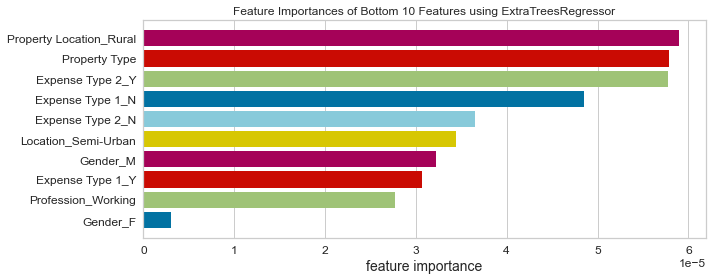

In [144]:
feat_importance(best_extra_tree_trn, model_name)

## 5.4 Bagging Regression

In [145]:
parameters = [
    {
    'base_estimator': [None, LinearRegression(), KNeighborsRegressor()],
    'n_estimators': [20,50,100],
    'max_samples': [0.5,1.0, n_samples//2,],
    'max_features': [0.5,1.0, n_features//2,],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
    }
]

In [146]:
bagging_reg_dict = {'Bagging Regression': BaggingRegressor(random_state=42)}

In [147]:
model_name, model = list(bagging_reg_dict.keys())[0], list(bagging_reg_dict.values())[0]

In [148]:
folder_check_model(model_name)

In [149]:
best_model = fine_tune_model(model_name, model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
**************************************************
29059.349267521986 {'n_estimators': 20, 'max_samples': 10738, 'max_features': 16, 'bootstrap_features': False, 'bootstrap': False, 'base_estimator': KNeighborsRegressor()}
26326.153876059747 {'n_estimators': 50, 'max_samples': 10738, 'max_features': 1.0, 'bootstrap_features': False, 'bootstrap': False, 'base_estimator': LinearRegression()}
26900.219056938 {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': True, 'base_estimator': LinearRegression()}
24196.673455826898 {'n_estimators': 50, 'max_samples': 1.0, 'max_features': 16, 'bootstrap_features': False, 'bootstrap': False, 'base_estimator': None}
24047.36281143294 {'n_estimators': 50, 'max_samples': 10738, 'max_features': 16, 'bootstrap_features': False, 'bootstrap': True, 'base_estimator': None}
24083.185633451427 {'n_estimators': 50, 'max_samples': 0.5, 'max_features': 

In [150]:
best_bagging_trn = train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)

## 5.5 Final model

We did hyperparameter tuning for the top 4 models, but only the random forest regressor yield an improved score. We will use that model with those parameters.

In [151]:
best_rand_for_trn

RandomForestRegressor(max_depth=10, max_features='auto', min_samples_leaf=2,
                      n_estimators=800, random_state=42)

# 6. Test the final model on the test dataset

In [152]:
loan_amt_test_copy.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-25648,Necole Newbold,M,48,2631.710,Low,Working,Drivers,Semi-Urban,65466.320,519.540,Y,Y,4.000,646.630,0,Unpossessed,582,2631.710,3,Urban,1,72111.030,0.000
1,C-27924,Ranee Yager,F,58,4445.650,NaN,Commercial associate,Laborers,Urban,88846.600,392.920,Y,Y,3.000,701.170,0,Unpossessed,319,4445.650,1,Semi-Urban,1,106418.120,62192.620
2,C-27842,Ivory Toledo,M,25,1586.370,Low,Commercial associate,Sales staff,Semi-Urban,142786.480,479.470,N,Y,2.000,673.920,1,Inactive,109,1586.370,4,Urban,1,181177.470,99950.540
3,C-7269,Todd Turcios,F,18,NaN,Low,Commercial associate,Core staff,Semi-Urban,119311.640,433.590,N,Y,3.000,610.330,0,Inactive,267,NaN,2,Rural,1,213450.090,0.000
4,C-47464,Beatriz Lessman,F,36,1591.720,Low,Working,Sales staff,Semi-Urban,48373.340,241.160,N,Y,3.000,728.090,0,Unpossessed,641,1591.720,4,Rural,1,74100.660,0.000


## 6.1 Data preprocessing for the test set

In [153]:
loan_amt_test_copy_prep = full_pipeline(loan_amt_test_copy)

In [154]:
loan_amt_test_copy_prep

,Gender_F,Gender_M,Profession_Commercial associate,Profession_Pensioner,Profession_State servant,Profession_Working,Location_Rural,Location_Semi-Urban,Location_Urban,Expense Type 1_N,Expense Type 1_Y,Expense Type 2_N,Expense Type 2_Y,Has Active Credit Card_Active,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Rural,Property Location_Semi-Urban,Property Location_Urban,Income Stability_High,Income Stability_Low,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.638,0.650,0.503,0.721,4.000,0.210,0,0.650,3,1,0.205,0.000
1,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.851,0.911,0.604,0.606,3.000,0.387,0,0.911,1,1,0.303,62192.620
2,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.149,0.438,0.781,0.687,2.000,0.298,1,0.438,4,1,0.516,99950.540
3,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.551,0.710,0.645,3.000,0.091,0,0.551,2,1,0.608,0.000
4,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.383,0.440,0.414,0.430,3.000,0.475,0,0.440,4,1,0.211,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5993,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.672,0.777,0.712,4.000,0.775,0,0.672,2,1,0.639,106164.560
5994,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.745,0.843,0.468,0.479,1.000,0.400,0,0.551,1,1,0.217,37951.710
5995,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.681,0.461,0.126,0.245,1.000,0.461,0,0.461,4,1,0.068,9736.100
5997,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.733,0.555,0.595,2.000,0.729,0,0.733,1,1,0.242,57763.880


In [155]:
X_loan_amt_test_prep, y_loan_amt_test_prep = loan_amt_test_copy_prep.loc[:, loan_amt_test_copy_prep.columns != 'Loan Sanction Amount (USD)'], loan_amt_test_copy_prep['Loan Sanction Amount (USD)']

## 6.2 RMSE on the Test Set

In [156]:
final_predictions = best_rand_for_trn.predict(X_loan_amt_test_prep)

In [157]:
final_mse = mean_squared_error(y_loan_amt_test_prep, final_predictions)

In [158]:
final_rmse = np.sqrt(final_mse)

In [159]:
final_rmse

20813.021511863957

## 6.3 Confidence Intervals

In [160]:
confidence = 0.95

In [161]:
squared_errors = (final_predictions - y_loan_amt_test_prep) ** 2

In [162]:
ci = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

In [163]:
print('The confidence interval at 95% is between {0:.2f} and {1:.2f}'.format(ci[0], ci[1]))

The confidence interval at 95% is between 19596.71 and 21962.07
